# Projet 5 :
# Segmentez des clients d'un site e-commerce

 Olist est une entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne.
 
 On doit fournir à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.
 
### Objectif 

- Comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.
- Fournir à l’équipe marketing une description actionable de la segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

### Les données
Pour cette mission, Olist fournit une base de données anonymisée comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.
### Mission
Aider les équipes d’Olist à comprendre les différents types d'utilisateurs(avec des méthodes non supervisées) pour regrouper des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe Marketing pour mieux communiquer.

On va réaliser 4 documents afin de préparer une réponse à Olist : 

- Un notebook d’analyse exploratoire.
- Un notebook avec des essais des différentes approches de modélisation.
- Un notebook de simulation pour déterminer la fréquence nécessaire de mise à jour du modèle de segmentation, afin que celui-ci reste pertinent.
- Une présentation pour un collègue afin d’obtenir ses retours sur votre approche.

### Chargement des bibliothèques et des données

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from datetime import *
from sklearn.cluster import KMeans
!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score


In [2]:
# installer folium
!pip install folium
import folium

In [3]:
# Chargement des données 
df_customers = pd.read_csv('olist_customers_dataset.csv', sep=',')
df_geolocation = pd.read_csv('olist_geolocation_dataset.csv', sep=',')
df_items = pd.read_csv('olist_order_items_dataset.csv', sep=',')
df_payments = pd.read_csv('olist_order_payments_dataset.csv', sep=',')
df_reviews = pd.read_csv('olist_order_reviews_dataset.csv', sep=',')
df_orders = pd.read_csv('olist_orders_dataset.csv', sep=',')
df_products = pd.read_csv('olist_products_dataset.csv', sep=',')
df_sellers = pd.read_csv('olist_sellers_dataset.csv', sep=',')
df_category = pd.read_csv('product_category_name_translation.csv', sep=',')

### Data schema

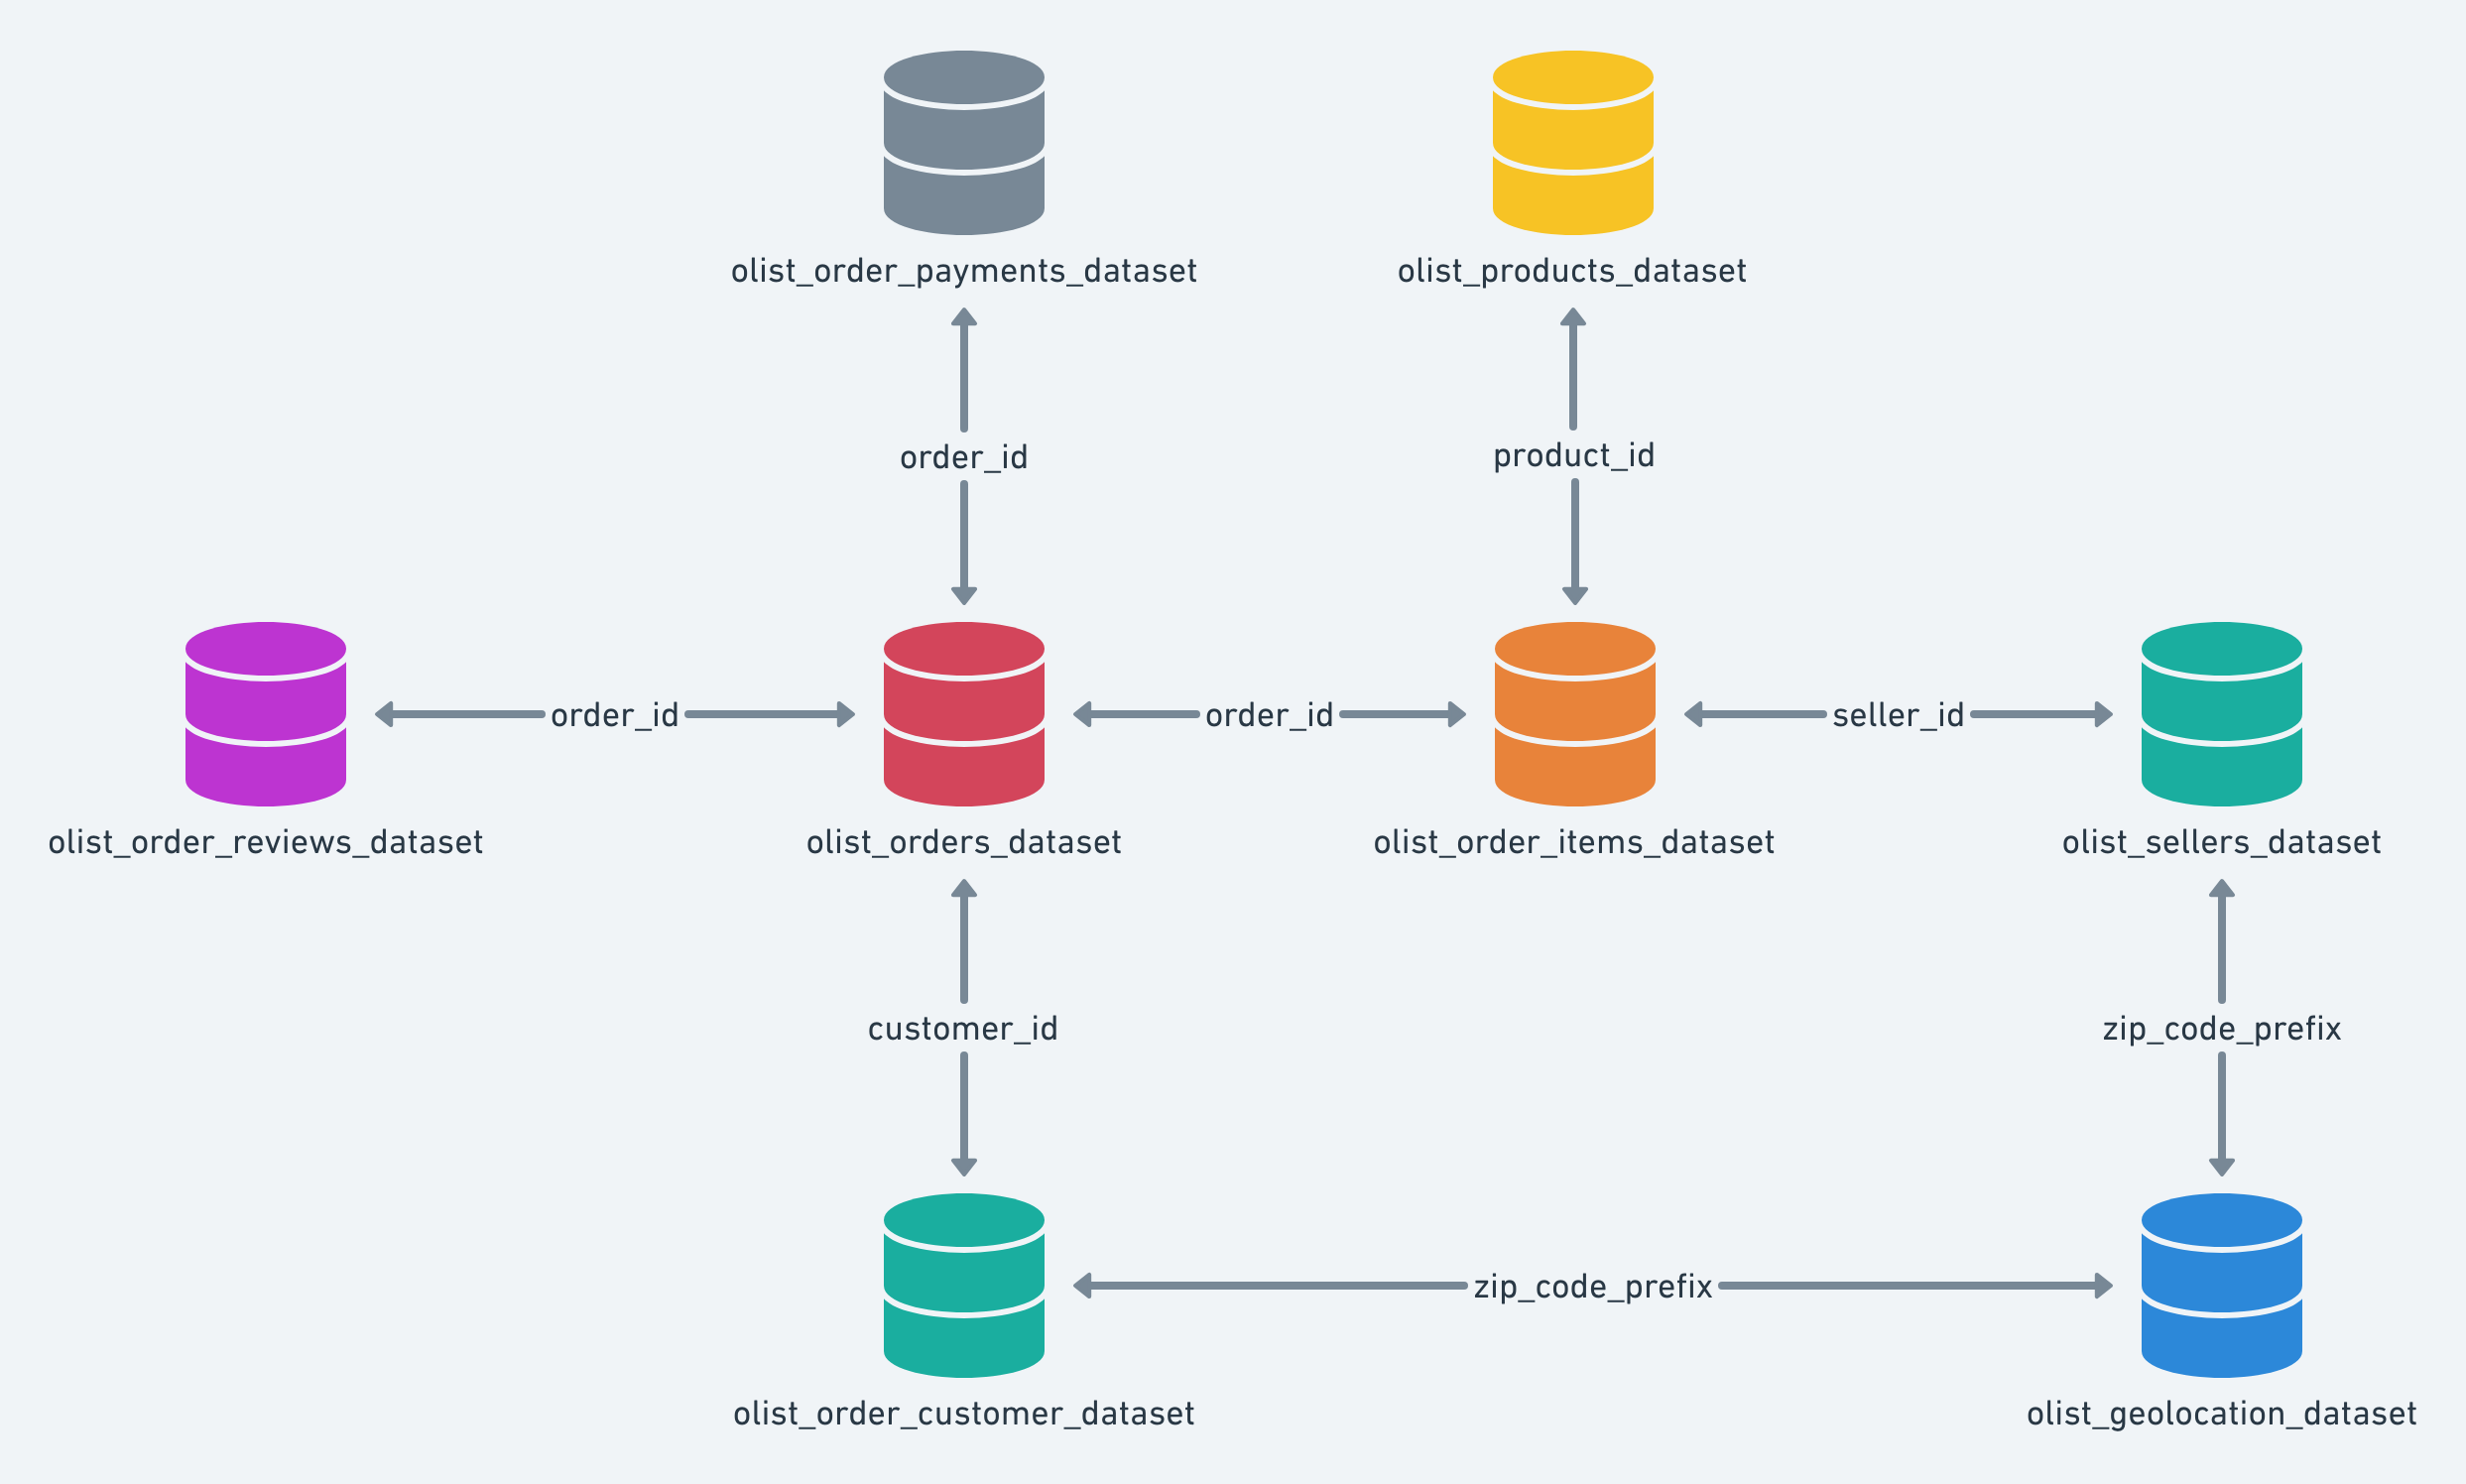

In [4]:
# afficher le jeu de données df_customers
df_customers

customer_id                customer_unique_id  \
0      06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1      18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2      4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3      b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4      4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
...                                 ...                               ...   
99436  17ddf5dd5d51696bb3d7c6291687be6f  1a29b476fee25c95fbafc67c5ac95cf8   
99437  e7b71a9017aa05c9a7fd292d714858e8  d52a67c98be1cf6a5c84435bd38d095d   
99438  5e28dfe12db7fb50a4b2f691faecea5e  e9f50caf99f032f0bf3c55141f019d99   
99439  56b18e2166679b8a959d72dd06da27f9  73c2643a0a458b49f58cea58833b192e   
99440  274fa6071e5e17fe303b9748641082c8  84732c5050c01db9b23e19ba39899398   

       customer_zip_code_prefix          customer_city customer_state  
0                         14409                 franca             SP  
1                          9790  sao bernardo do campo             SP  
2                          1151              sao paulo             SP  
3                          8775        mogi das cruzes             SP  
4                         13056               campinas             SP  
...                         ...                    ...            ...  
99436                      3937              sao paulo             SP  
99437                      6764        taboao da serra             SP  
99438                     60115              fortaleza             CE  
99439                     92120                 canoas             RS  
99440                      6703                  cotia             SP  

[99441 rows x 5 columns]

Text(0.5, 1.0, '% Valeurs non nulles dans le jeu de données df_customers')

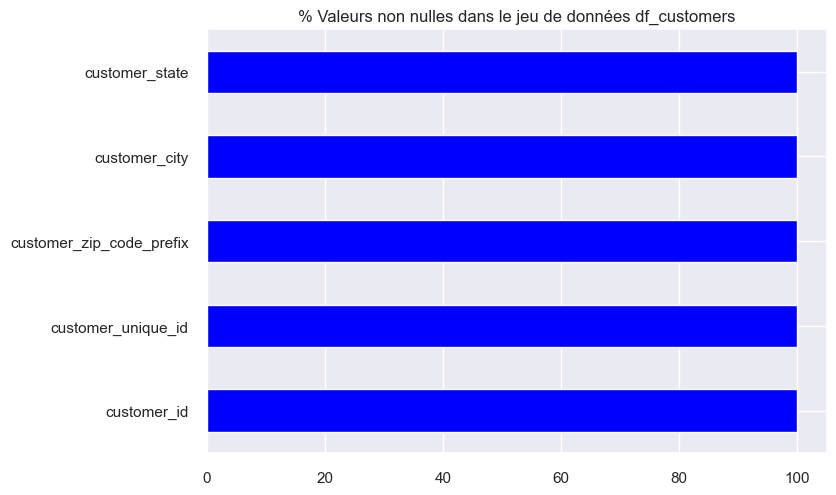

In [5]:
# visualisation du pourcentage de Valeurs manquantes dans le jeu de données df_customers
sns.set_theme()
taille = df_customers.shape
valeurs_notnull = df_customers.notnull().sum()
valeurs_notnull = valeurs_notnull.sort_values(ascending=True)*100/taille[0]
figure = valeurs_notnull.plot(kind='barh',color='blue')
figure.set_title("% Valeurs non nulles dans le jeu de données df_customers")

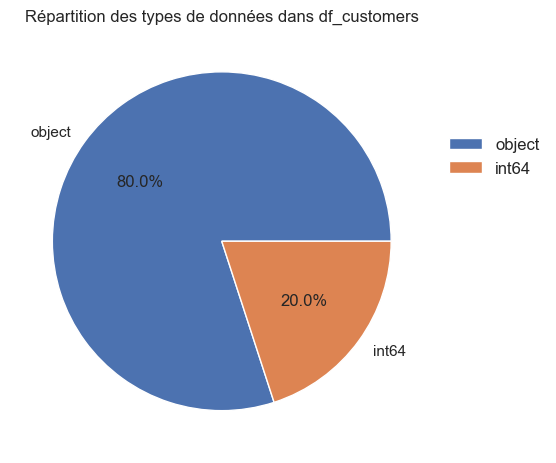

In [6]:
# visualisation de types des données dans le jeu de données df_customers

df_customers.dtypes.value_counts().plot(kind='pie', autopct='%1.1f%%', 
                                   title="Répartition des types de données dans df_customers",
                                   legend=False, label="")

ax = plt.gca()
ax.legend(loc="center left",
          fontsize=12,
          bbox_to_anchor=(1, 0.2, 0.5, 1))
sns.set_theme()
plt.show()

In [7]:
# afficher le jeu de données df_geolocation
df_geolocation

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                               1037       -23.545621       -46.639292   
1                               1046       -23.546081       -46.644820   
2                               1046       -23.546129       -46.642951   
3                               1041       -23.544392       -46.639499   
4                               1035       -23.541578       -46.641607   
...                              ...              ...              ...   
1000158                        99950       -28.068639       -52.010705   
1000159                        99900       -27.877125       -52.224882   
1000160                        99950       -28.071855       -52.014716   
1000161                        99980       -28.388932       -51.846871   
1000162                        99950       -28.070104       -52.018658   

        geolocation_city geolocation_state  
0              sao paulo                SP  
1              sao paulo                SP  
2              sao paulo                SP  
3              sao paulo                SP  
4              sao paulo                SP  
...                  ...               ...  
1000158         tapejara                RS  
1000159   getulio vargas                RS  
1000160         tapejara                RS  
1000161  david canabarro                RS  
1000162         tapejara                RS  

[1000163 rows x 5 columns]

Text(0.5, 1.0, '% Valeurs non nulles dans le jeu de données df_geolocation')

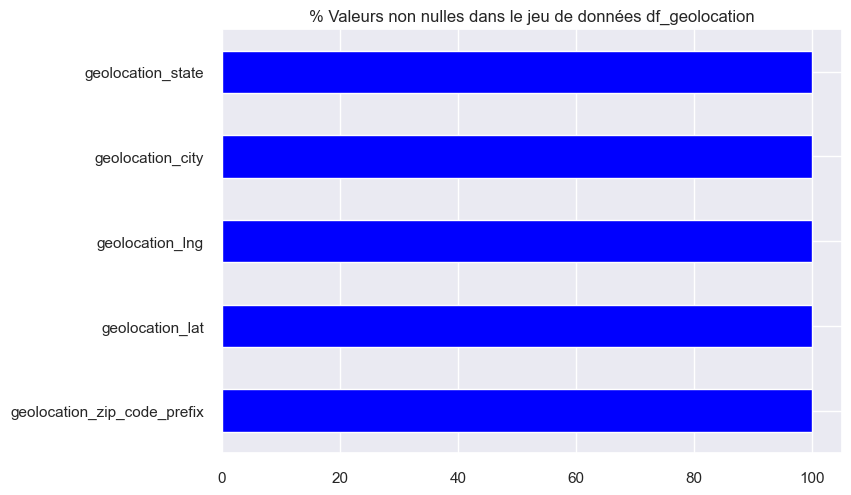

In [8]:
# visualisation du pourcentage de Valeurs manquantes dans le jeu de données df_geolocation
sns.set_theme()
taille = df_geolocation.shape
valeurs_notnull = df_geolocation.notnull().sum()
valeurs_notnull = valeurs_notnull.sort_values(ascending=True)*100/taille[0]
figure = valeurs_notnull.plot(kind='barh',color='blue')
figure.set_title("% Valeurs non nulles dans le jeu de données df_geolocation")

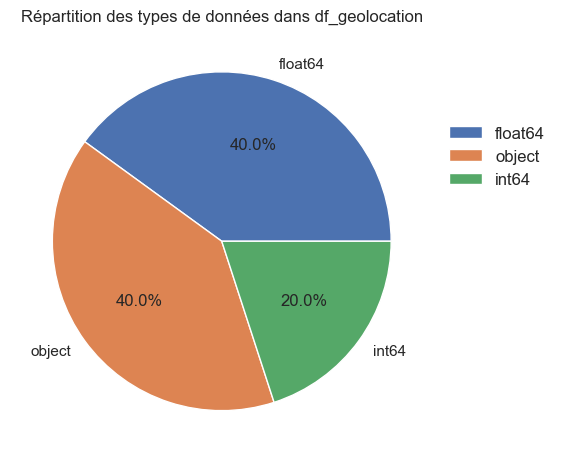

In [9]:
# visualisation de types des données dans le jeu de données df_geolocation

df_geolocation.dtypes.value_counts().plot(kind='pie', autopct='%1.1f%%', 
                                   title="Répartition des types de données dans df_geolocation",
                                   legend=False, label="")

ax = plt.gca()
ax.legend(loc="center left",
          fontsize=12,
          bbox_to_anchor=(1, 0.2, 0.5, 1))
sns.set_theme()
plt.show()

In [10]:
# afficher le jeu de données df_items
df_items

order_id  order_item_id  \
0       00010242fe8c5a6d1ba2dd792cb16214              1   
1       00018f77f2f0320c557190d7a144bdd3              1   
2       000229ec398224ef6ca0657da4fc703e              1   
3       00024acbcdf0a6daa1e931b038114c75              1   
4       00042b26cf59d7ce69dfabb4e55b4fd9              1   
...                                  ...            ...   
112645  fffc94f6ce00a00581880bf54a75a037              1   
112646  fffcd46ef2263f404302a634eb57f7eb              1   
112647  fffce4705a9662cd70adb13d4a31832d              1   
112648  fffe18544ffabc95dfada21779c9644f              1   
112649  fffe41c64501cc87c801fd61db3f6244              1   

                              product_id                         seller_id  \
0       4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1       e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2       c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3       7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4       ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   
...                                  ...                               ...   
112645  4aa6014eceb682077f9dc4bffebc05b0  b8bc237ba3788b23da09c0f1f3a3288c   
112646  32e07fd915822b0765e448c4dd74c828  f3c38ab652836d21de61fb8314b69182   
112647  72a30483855e2eafc67aee5dc2560482  c3cfdc648177fdbbbb35635a37472c53   
112648  9c422a519119dcad7575db5af1ba540e  2b3e4a2a3ea8e01938cabda2a3e5cc79   
112649  350688d9dc1e75ff97be326363655e01  f7ccf836d21b2fb1de37564105216cc1   

        shipping_limit_date   price  freight_value  
0       2017-09-19 09:45:35   58.90          13.29  
1       2017-05-03 11:05:13  239.90          19.93  
2       2018-01-18 14:48:30  199.00          17.87  
3       2018-08-15 10:10:18   12.99          12.79  
4       2017-02-13 13:57:51  199.90          18.14  
...                     ...     ...            ...  
112645  2018-05-02 04:11:01  299.99          43.41  
112646  2018-07-20 04:31:48  350.00          36.53  
112647  2017-10-30 17:14:25   99.90          16.95  
112648  2017-08-21 00:04:32   55.99           8.72  
112649  2018-06-12 17:10:13   43.00          12.79  

[112650 rows x 7 columns]

Text(0.5, 1.0, '% Valeurs non nulles dans le jeu de données df_items')

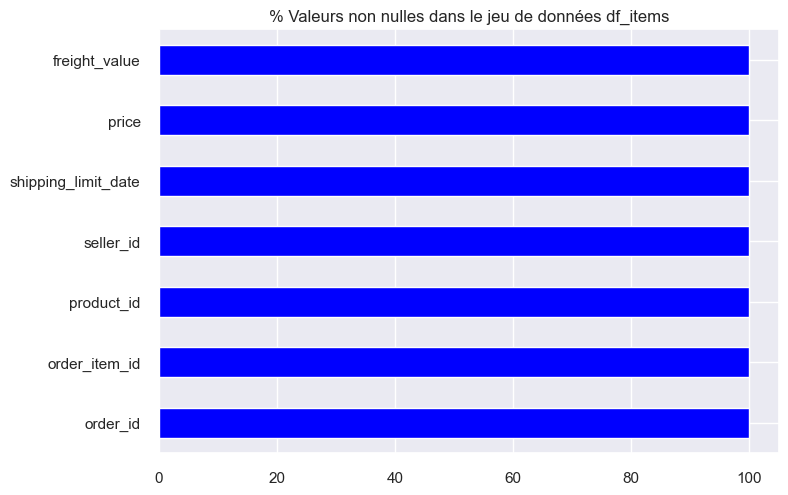

In [11]:
# visualisation du pourcentage de Valeurs manquantes dans le jeu de données df_items
sns.set_theme()
taille = df_items.shape
valeurs_notnull = df_items.notnull().sum()
valeurs_notnull = valeurs_notnull.sort_values(ascending=True)*100/taille[0]
figure = valeurs_notnull.plot(kind='barh',color='blue')
figure.set_title("% Valeurs non nulles dans le jeu de données df_items")

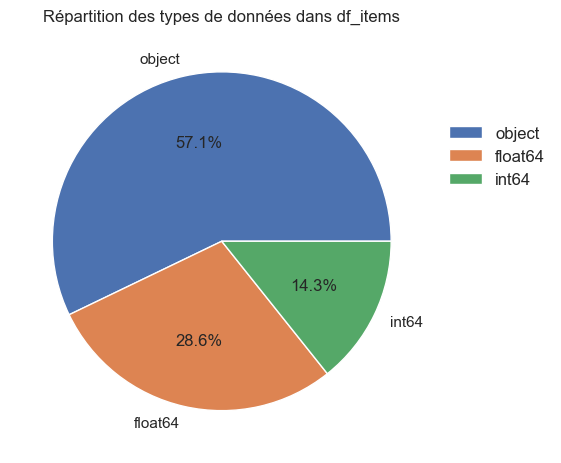

In [12]:
# visualisation de types des données dans le jeu de données df_items

df_items.dtypes.value_counts().plot(kind='pie', autopct='%1.1f%%', 
                                   title="Répartition des types de données dans df_items",
                                   legend=False, label="")

ax = plt.gca()
ax.legend(loc="center left",
          fontsize=12,
          bbox_to_anchor=(1, 0.2, 0.5, 1))
sns.set_theme()
plt.show()

In [13]:
# afficher le jeu de données df_payments
df_payments

order_id  payment_sequential payment_type  \
0       b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1       a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2       25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   
3       ba78997921bbcdc1373bb41e913ab953                   1  credit_card   
4       42fdf880ba16b47b59251dd489d4441a                   1  credit_card   
...                                  ...                 ...          ...   
103881  0406037ad97740d563a178ecc7a2075c                   1       boleto   
103882  7b905861d7c825891d6347454ea7863f                   1  credit_card   
103883  32609bbb3dd69b3c066a6860554a77bf                   1  credit_card   
103884  b8b61059626efa996a60be9bb9320e10                   1  credit_card   
103885  28bbae6599b09d39ca406b747b6632b1                   1       boleto   

        payment_installments  payment_value  
0                          8          99.33  
1                          1          24.39  
2                          1          65.71  
3                          8         107.78  
4                          2         128.45  
...                      ...            ...  
103881                     1         363.31  
103882                     2          96.80  
103883                     1          47.77  
103884                     5         369.54  
103885                     1         191.58  

[103886 rows x 5 columns]

Text(0.5, 1.0, '% Valeurs non nulles dans le jeu de données df_payments')

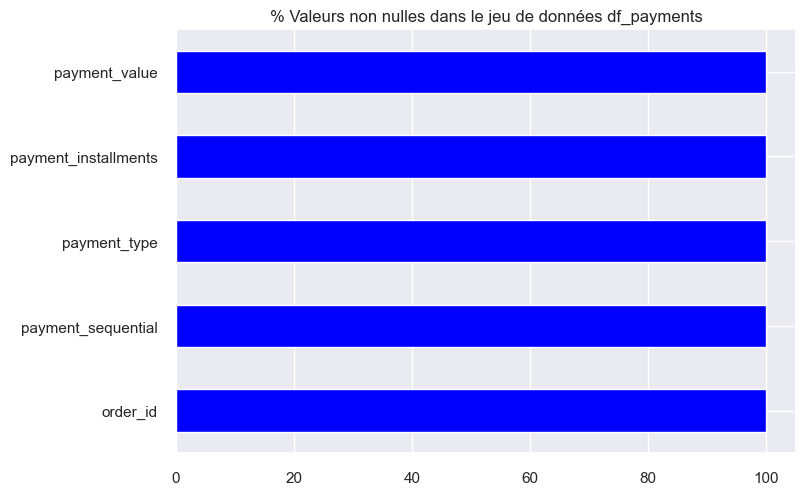

In [14]:
# visualisation du pourcentage de Valeurs manquantes dans le jeu de données df_payments
sns.set_theme()
taille = df_payments.shape
valeurs_notnull = df_payments.notnull().sum()
valeurs_notnull = valeurs_notnull.sort_values(ascending=True)*100/taille[0]
figure = valeurs_notnull.plot(kind='barh',color='blue')
figure.set_title("% Valeurs non nulles dans le jeu de données df_payments")

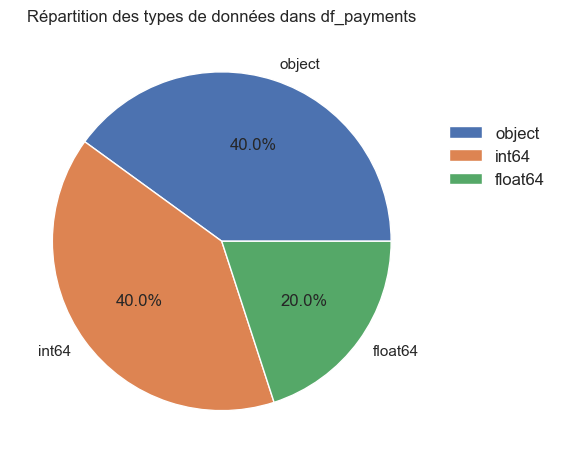

In [15]:
# visualisation de types des données dans le jeu de données df_items

df_payments.dtypes.value_counts().plot(kind='pie', autopct='%1.1f%%', 
                                   title="Répartition des types de données dans df_payments",
                                   legend=False, label="")

ax = plt.gca()
ax.legend(loc="center left",
          fontsize=12,
          bbox_to_anchor=(1, 0.2, 0.5, 1))
sns.set_theme()
plt.show()

In [16]:
# afficher le jeu de données df_reviews
df_reviews

review_id                          order_id  \
0      7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1      80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2      228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3      e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4      f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   
...                                 ...                               ...   
99219  574ed12dd733e5fa530cfd4bbf39d7c9  2a8c23fee101d4d5662fa670396eb8da   
99220  f3897127253a9592a73be9bdfdf4ed7a  22ec9f0669f784db00fa86d035cf8602   
99221  b3de70c89b1510c4cd3d0649fd302472  55d4004744368f5571d1f590031933e4   
99222  1adeb9d84d72fe4e337617733eb85149  7725825d039fc1f0ceb7635e3f7d9206   
99223  efe49f1d6f951dd88b51e6ccd4cc548f  90531360ecb1eec2a1fbb265a0db0508   

       review_score review_comment_title  \
0                 4                  NaN   
1                 5                  NaN   
2                 5                  NaN   
3                 5                  NaN   
4                 5                  NaN   
...             ...                  ...   
99219             5                  NaN   
99220             5                  NaN   
99221             5                  NaN   
99222             4                  NaN   
99223             1                  NaN   

                                  review_comment_message review_creation_date  \
0                                                    NaN  2018-01-18 00:00:00   
1                                                    NaN  2018-03-10 00:00:00   
2                                                    NaN  2018-02-17 00:00:00   
3                  Recebi bem antes do prazo estipulado.  2017-04-21 00:00:00   
4      Parabéns lojas lannister adorei comprar pela I...  2018-03-01 00:00:00   
...                                                  ...                  ...   
99219                                                NaN  2018-07-07 00:00:00   
99220                                                NaN  2017-12-09 00:00:00   
99221  Excelente mochila, entrega super rápida. Super...  2018-03-22 00:00:00   
99222                                                NaN  2018-07-01 00:00:00   
99223  meu produto chegou e ja tenho que devolver, po...  2017-07-03 00:00:00   

      review_answer_timestamp  
0         2018-01-18 21:46:59  
1         2018-03-11 03:05:13  
2         2018-02-18 14:36:24  
3         2017-04-21 22:02:06  
4         2018-03-02 10:26:53  
...                       ...  
99219     2018-07-14 17:18:30  
99220     2017-12-11 20:06:42  
99221     2018-03-23 09:10:43  
99222     2018-07-02 12:59:13  
99223     2017-07-03 21:01:49  

[99224 rows x 7 columns]

Text(0.5, 1.0, '% Valeurs non nulles dans le jeu de données df_reviews')

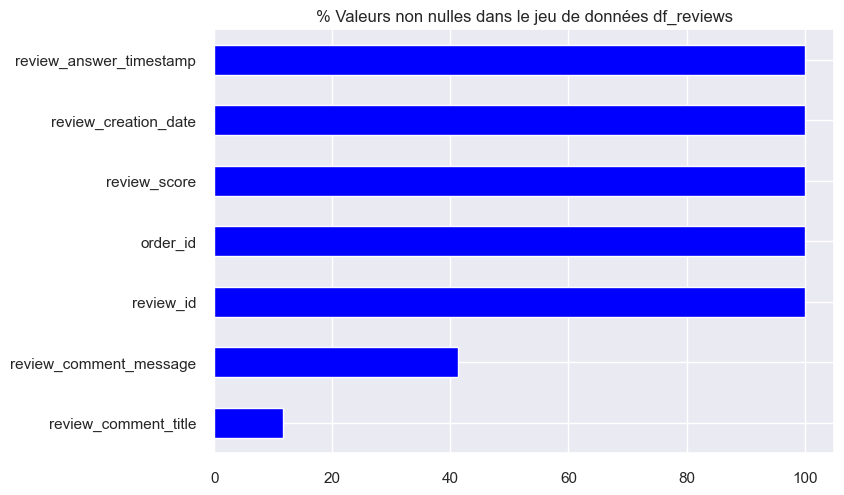

In [17]:
# visualisation du pourcentage de Valeurs manquantes dans le jeu de données df_reviews
sns.set_theme()
taille = df_reviews.shape
valeurs_notnull = df_reviews.notnull().sum()
valeurs_notnull = valeurs_notnull.sort_values(ascending=True)*100/taille[0]
figure = valeurs_notnull.plot(kind='barh',color='blue')
figure.set_title("% Valeurs non nulles dans le jeu de données df_reviews")

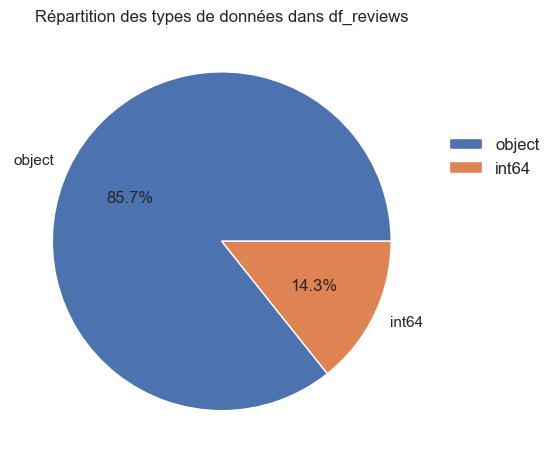

In [18]:
# visualisation de types des données dans le jeu de données df_reviews

df_reviews.dtypes.value_counts().plot(kind='pie', autopct='%1.1f%%', 
                                   title="Répartition des types de données dans df_reviews",
                                   legend=False, label="")

ax = plt.gca()
ax.legend(loc="center left",
          fontsize=12,
          bbox_to_anchor=(1, 0.2, 0.5, 1))
sns.set_theme()
plt.show()

In [19]:
# afficher le jeu de données df_orders
df_orders

order_id                       customer_id  \
0      e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1      53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2      47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3      949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4      ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                 ...                               ...   
99436  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
99437  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
99438  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
99439  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
99440  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

      order_status order_purchase_timestamp    order_approved_at  \
0        delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1        delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2        delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3        delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4        delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   
...            ...                      ...                  ...   
99436    delivered      2017-03-09 09:54:05  2017-03-09 09:54:05   
99437    delivered      2018-02-06 12:58:58  2018-02-06 13:10:37   
99438    delivered      2017-08-27 14:46:43  2017-08-27 15:04:16   
99439    delivered      2018-01-08 21:28:27  2018-01-08 21:36:21   
99440    delivered      2018-03-08 20:57:30  2018-03-09 11:20:28   

      order_delivered_carrier_date order_delivered_customer_date  \
0              2017-10-04 19:55:00           2017-10-10 21:25:13   
1              2018-07-26 14:31:00           2018-08-07 15:27:45   
2              2018-08-08 13:50:00           2018-08-17 18:06:29   
3              2017-11-22 13:39:59           2017-12-02 00:28:42   
4              2018-02-14 19:46:34           2018-02-16 18:17:02   
...                            ...                           ...   
99436          2017-03-10 11:18:03           2017-03-17 15:08:01   
99437          2018-02-07 23:22:42           2018-02-28 17:37:56   
99438          2017-08-28 20:52:26           2017-09-21 11:24:17   
99439          2018-01-12 15:35:03           2018-01-25 23:32:54   
99440          2018-03-09 22:11:59           2018-03-16 13:08:30   

      order_estimated_delivery_date  
0               2017-10-18 00:00:00  
1               2018-08-13 00:00:00  
2               2018-09-04 00:00:00  
3               2017-12-15 00:00:00  
4               2018-02-26 00:00:00  
...                             ...  
99436           2017-03-28 00:00:00  
99437           2018-03-02 00:00:00  
99438           2017-09-27 00:00:00  
99439           2018-02-15 00:00:00  
99440           2018-04-03 00:00:00  

[99441 rows x 8 columns]

Text(0.5, 1.0, '% Valeurs non nulles dans le jeu de données df_orders')

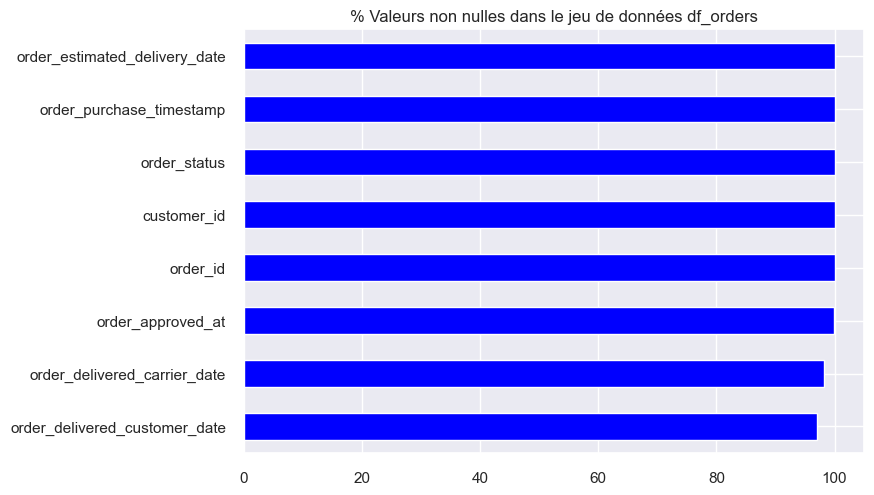

In [20]:
# visualisation du pourcentage de Valeurs manquantes dans le jeu de données df_orders
sns.set_theme()
taille = df_orders.shape
valeurs_notnull = df_orders.notnull().sum()
valeurs_notnull = valeurs_notnull.sort_values(ascending=True)*100/taille[0]
figure = valeurs_notnull.plot(kind='barh',color='blue')
figure.set_title("% Valeurs non nulles dans le jeu de données df_orders")

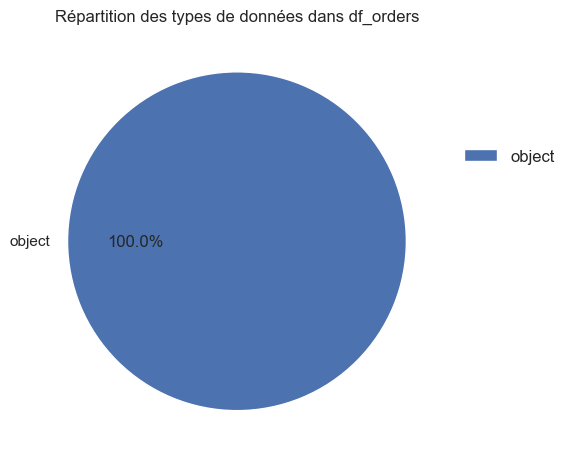

In [21]:
# visualisation de types des données dans le jeu de données df_orders

df_orders.dtypes.value_counts().plot(kind='pie', autopct='%1.1f%%', 
                                   title="Répartition des types de données dans df_orders",
                                   legend=False, label="")

ax = plt.gca()
ax.legend(loc="center left",
          fontsize=12,
          bbox_to_anchor=(1, 0.2, 0.5, 1))
sns.set_theme()
plt.show()

In [22]:
# afficher le jeu de données df_products
df_products

product_id              product_category_name  \
0      1e9e8ef04dbcff4541ed26657ea517e5                         perfumaria   
1      3aa071139cb16b67ca9e5dea641aaa2f                              artes   
2      96bd76ec8810374ed1b65e291975717f                      esporte_lazer   
3      cef67bcfe19066a932b7673e239eb23d                              bebes   
4      9dc1a7de274444849c219cff195d0b71              utilidades_domesticas   
...                                 ...                                ...   
32946  a0b7d5a992ccda646f2d34e418fff5a0                   moveis_decoracao   
32947  bf4538d88321d0fd4412a93c974510e6  construcao_ferramentas_iluminacao   
32948  9a7c6041fa9592d9d9ef6cfe62a71f8c                    cama_mesa_banho   
32949  83808703fc0706a22e264b9d75f04a2e             informatica_acessorios   
32950  106392145fca363410d287a815be6de4                    cama_mesa_banho   

       product_name_lenght  product_description_lenght  product_photos_qty  \
0                     40.0                       287.0                 1.0   
1                     44.0                       276.0                 1.0   
2                     46.0                       250.0                 1.0   
3                     27.0                       261.0                 1.0   
4                     37.0                       402.0                 4.0   
...                    ...                         ...                 ...   
32946                 45.0                        67.0                 2.0   
32947                 41.0                       971.0                 1.0   
32948                 50.0                       799.0                 1.0   
32949                 60.0                       156.0                 2.0   
32950                 58.0                       309.0                 1.0   

       product_weight_g  product_length_cm  product_height_cm  \
0                 225.0               16.0               10.0   
1                1000.0               30.0               18.0   
2                 154.0               18.0                9.0   
3                 371.0               26.0                4.0   
4                 625.0               20.0               17.0   
...                 ...                ...                ...   
32946           12300.0               40.0               40.0   
32947            1700.0               16.0               19.0   
32948            1400.0               27.0                7.0   
32949             700.0               31.0               13.0   
32950            2083.0               12.0                2.0   

       product_width_cm  
0                  14.0  
1                  20.0  
2                  15.0  
3                  26.0  
4                  13.0  
...                 ...  
32946              40.0  
32947              16.0  
32948              27.0  
32949              20.0  
32950               7.0  

[32951 rows x 9 columns]

Text(0.5, 1.0, '% Valeurs non nulles dans le jeu de données df_products')

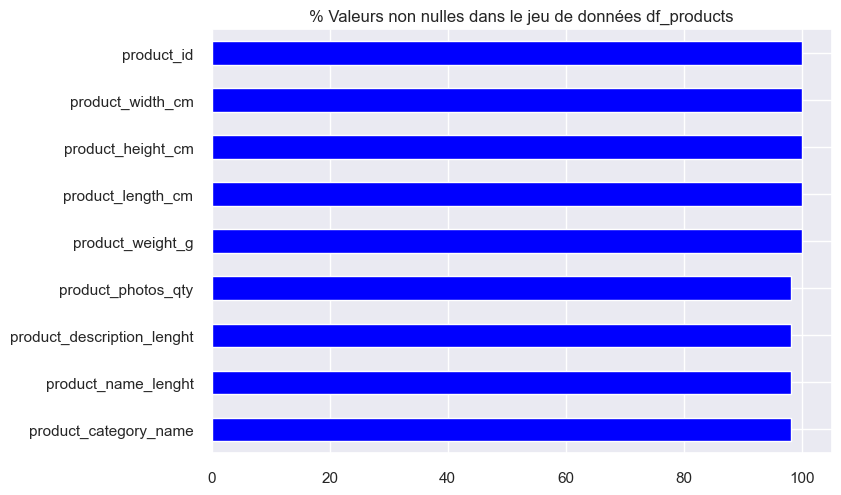

In [23]:
# visualisation du pourcentage de Valeurs manquantes dans le jeu de données df_products
sns.set_theme()
taille = df_products.shape
valeurs_notnull = df_products.notnull().sum()
valeurs_notnull = valeurs_notnull.sort_values(ascending=True)*100/taille[0]
figure = valeurs_notnull.plot(kind='barh',color='blue')
figure.set_title("% Valeurs non nulles dans le jeu de données df_products")

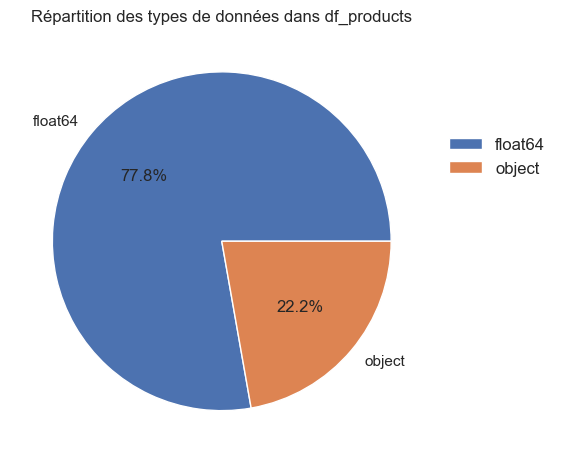

In [24]:
# visualisation de types des données dans le jeu de données df_products

df_products.dtypes.value_counts().plot(kind='pie', autopct='%1.1f%%', 
                                   title="Répartition des types de données dans df_products",
                                   legend=False, label="")

ax = plt.gca()
ax.legend(loc="center left",
          fontsize=12,
          bbox_to_anchor=(1, 0.2, 0.5, 1))
sns.set_theme()
plt.show()

In [25]:
# afficher le jeu de données df_sellers
df_sellers

seller_id  seller_zip_code_prefix  \
0     3442f8959a84dea7ee197c632cb2df15                   13023   
1     d1b65fc7debc3361ea86b5f14c68d2e2                   13844   
2     ce3ad9de960102d0677a81f5d0bb7b2d                   20031   
3     c0f3eea2e14555b6faeea3dd58c1b1c3                    4195   
4     51a04a8a6bdcb23deccc82b0b80742cf                   12914   
...                                ...                     ...   
3090  98dddbc4601dd4443ca174359b237166                   87111   
3091  f8201cab383e484733266d1906e2fdfa                   88137   
3092  74871d19219c7d518d0090283e03c137                    4650   
3093  e603cf3fec55f8697c9059638d6c8eb5                   96080   
3094  9e25199f6ef7e7c347120ff175652c3b                   12051   

            seller_city seller_state  
0              campinas           SP  
1            mogi guacu           SP  
2        rio de janeiro           RJ  
3             sao paulo           SP  
4     braganca paulista           SP  
...                 ...          ...  
3090            sarandi           PR  
3091            palhoca           SC  
3092          sao paulo           SP  
3093            pelotas           RS  
3094            taubate           SP  

[3095 rows x 4 columns]

Text(0.5, 1.0, '% Valeurs non nulles dans le jeu de données df_sellers')

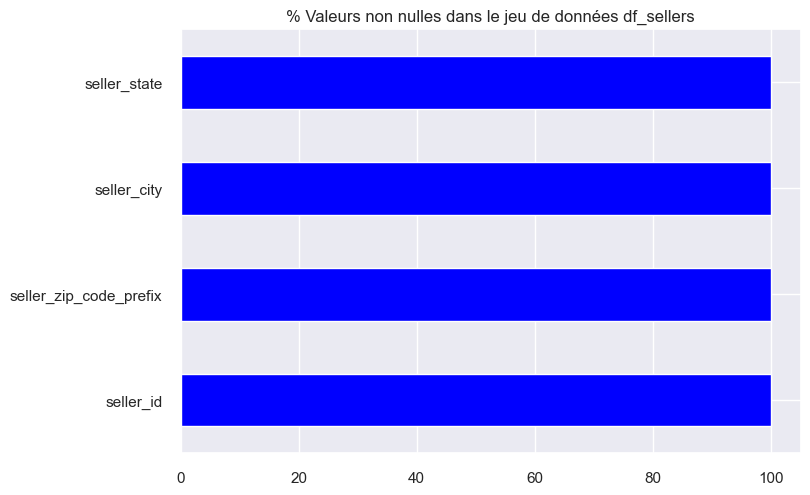

In [26]:
# visualisation du pourcentage de Valeurs manquantes dans le jeu de données df_sellers
sns.set_theme()
taille = df_sellers.shape
valeurs_notnull = df_sellers.notnull().sum()
valeurs_notnull = valeurs_notnull.sort_values(ascending=True)*100/taille[0]
figure = valeurs_notnull.plot(kind='barh',color='blue')
figure.set_title("% Valeurs non nulles dans le jeu de données df_sellers")

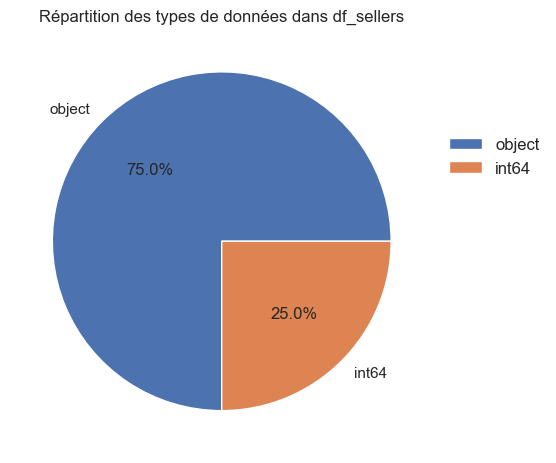

In [27]:
# visualisation de types des données dans le jeu de données df_sellers

df_sellers.dtypes.value_counts().plot(kind='pie', autopct='%1.1f%%', 
                                   title="Répartition des types de données dans df_sellers",
                                   legend=False, label="")

ax = plt.gca()
ax.legend(loc="center left",
          fontsize=12,
          bbox_to_anchor=(1, 0.2, 0.5, 1))
sns.set_theme()
plt.show()

In [28]:
# afficher le jeu de données df_category
df_category

product_category_name product_category_name_english
0                    beleza_saude                 health_beauty
1          informatica_acessorios         computers_accessories
2                      automotivo                          auto
3                 cama_mesa_banho                bed_bath_table
4                moveis_decoracao               furniture_decor
..                            ...                           ...
66                         flores                       flowers
67             artes_e_artesanato         arts_and_craftmanship
68                fraldas_higiene           diapers_and_hygiene
69  fashion_roupa_infanto_juvenil     fashion_childrens_clothes
70             seguros_e_servicos         security_and_services

[71 rows x 2 columns]

Text(0.5, 1.0, '% Valeurs non nulles dans le jeu de données df_category')

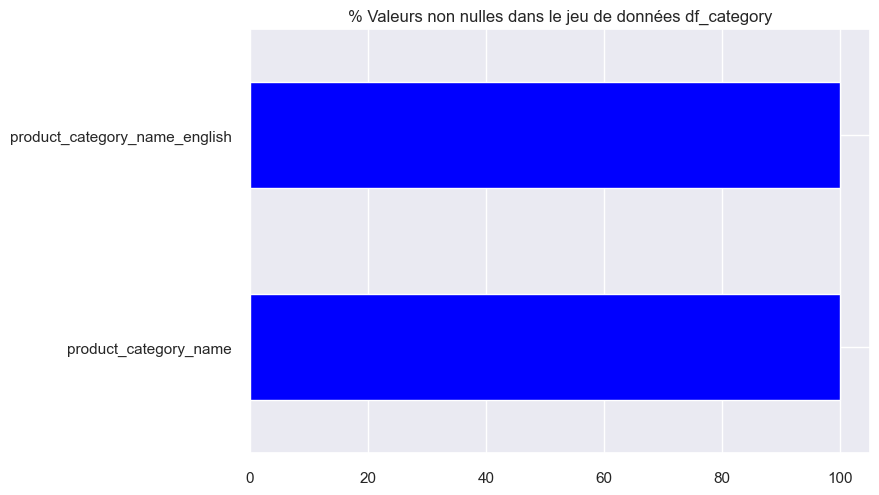

In [29]:
# visualisation du pourcentage de Valeurs manquantes dans le jeu de données df_category
sns.set_theme()
taille = df_category.shape
valeurs_notnull = df_category.notnull().sum()
valeurs_notnull = valeurs_notnull.sort_values(ascending=True)*100/taille[0]
figure = valeurs_notnull.plot(kind='barh',color='blue')
figure.set_title("% Valeurs non nulles dans le jeu de données df_category")

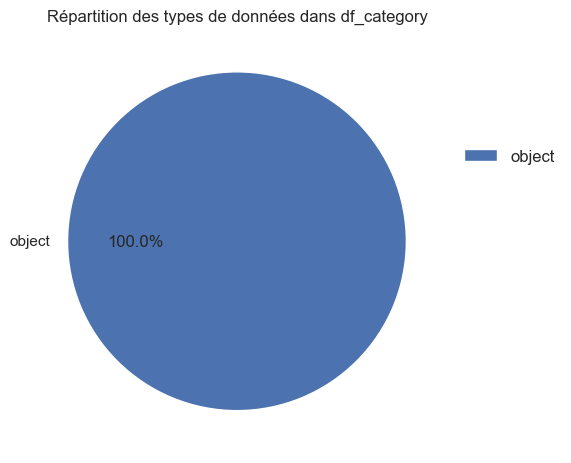

In [30]:
# visualisation de types des données dans le jeu de données df_category

df_category.dtypes.value_counts().plot(kind='pie', autopct='%1.1f%%', 
                                   title="Répartition des types de données dans df_category",
                                   legend=False, label="")

ax = plt.gca()
ax.legend(loc="center left",
          fontsize=12,
          bbox_to_anchor=(1, 0.2, 0.5, 1))
sns.set_theme()
plt.show()

 ## Traitement des données

In [31]:
# affichez le nom et les informations(taille et colonnes) de chaque dataframe
dfs = {'df_customers': df_customers, 'df_geolocation': df_geolocation, 'df_items': df_items, 
       'df_payments': df_payments, 'df_reviews': df_reviews, 'df_orders': df_orders, 
       'df_products': df_products, 'df_sellers': df_sellers, 'df_category': df_category}
for name, df in dfs.items():
    print('*'*90)
    print(f"{name}:")
    print(f"   Taille: {df.shape}")
    print(f"   Colonnes: {list(df.columns)}\n")

******************************************************************************************
df_customers:
   Taille: (99441, 5)
   Colonnes: ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']

******************************************************************************************
df_geolocation:
   Taille: (1000163, 5)
   Colonnes: ['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng', 'geolocation_city', 'geolocation_state']

******************************************************************************************
df_items:
   Taille: (112650, 7)
   Colonnes: ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']

******************************************************************************************
df_payments:
   Taille: (103886, 5)
   Colonnes: ['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']

*************************

Dans un premier temps, on va examiner à ces variables pour chaque jeu de données:

#### df_customers: clients

- customer_id: identifiant client
- customer_unique_id: identifiant unique client
- customer_state: état du client
- customer_zip_code_prefix: code postal du client

####  df_geolocation: géolocalisation

- geolocation_zip_code_prefix: code postal de géolocalisation
- geolocation_lat: latitude de géolocalisation
- geolocation_lng: longitude de géolocalisation

####  df_items: articles

- order_id: identifiant de commande
- order_item_id: identifiant d'article de commande
- product_id: identifiant de produit
- seller_id: identifiant de vendeur
- shipping_limit_date: date limite d'expédition
- price: prix de l'article
- freight_value: coût de livraison

####  df_payments:  paiements

- order_id: identifiant de commande
- payment_sequential: séquence de paiement
- payment_type: type de paiement
- payment_installments: nombre de paiements échelonnés
- payment_value: valeur du paiement

####  df_reviews: commentaires

- review_id: identifiant de commentaire
- order_id: identifiant de commande
- review_score: score de commentaire
- review_comment_title: titre de commentaire
- review_comment_message: message de commentaire
- review_creation_date: date de création de commentaire
- review_answer_timestamp: horodatage de réponse de commentaire
- order_approved_at: date à laquelle une commande a été approuvée

####  df_orders: commandes

- order_id: identifiant de commande
- customer_id: identifiant client
- order_status: état de commande
- order_purchase_timestamp: horodatage d'achat de commande
- order_delivered_customer_date : date de livraison au client


####  df_products: produits

- product_id: identifiant de produit
- product_category_name: nom de la catégorie de produit

####  df_sellers : vendeurs

- seller_id: identifiant de vendeur
- seller_zip_code_prefix: code postal de vendeur
- seller_city: ville de vendeur
- seller_state: état de vendeur


####  df_category: catégorie

- product_category_name: nom de la catégorie de produit
- product_category_name_english: nom anglais de la catégorie de produit

### Fusion des jeux de données

In [32]:
# Fusionner les jeux de données

# Fusionner df_customers avec df_orders en utilisant la variable "customer_id" comme clé de fusion.
df = pd.merge(df_customers, df_orders, on='customer_id', how='left')

# Fusionner le dataframe résultant avec df_reviews en utilisant la variable "order_id" comme clé de fusion.
df = pd.merge(df, df_reviews, on='order_id', how='left')

# Fusionner le dataframe résultant avec df_payments en utilisant la variable "order_id" comme clé de fusion.
df = pd.merge(df, df_payments, on='order_id', how='left')

# Fusionner le dataframe résultant avec df_items en utilisant la variable "order_id" comme clé de fusion.
df = pd.merge(df, df_items, on='order_id', how='left')

# Fusionner le dataframe résultant avec df_products en utilisant la variable "product_id" comme clé de fusion.
df = pd.merge(df, df_products, on='product_id', how='left')

# Fusionner le dataframe résultant avec df_category en utilisant la variable "product_category_name" comme clé de fusion.
df = pd.merge(df, df_category, on='product_category_name', how='left')

# Fusionner le dataframe résultant avec df_sellers en utilisant la variable "seller_id" comme clé de fusion.
df = pd.merge(df, df_sellers, on='seller_id', how='left')

# Afficher le résultat.
df


customer_id                customer_unique_id  \
0       06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1       18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2       4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3       b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4       4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
...                                  ...                               ...   
119138  17ddf5dd5d51696bb3d7c6291687be6f  1a29b476fee25c95fbafc67c5ac95cf8   
119139  e7b71a9017aa05c9a7fd292d714858e8  d52a67c98be1cf6a5c84435bd38d095d   
119140  5e28dfe12db7fb50a4b2f691faecea5e  e9f50caf99f032f0bf3c55141f019d99   
119141  56b18e2166679b8a959d72dd06da27f9  73c2643a0a458b49f58cea58833b192e   
119142  274fa6071e5e17fe303b9748641082c8  84732c5050c01db9b23e19ba39899398   

        customer_zip_code_prefix          customer_city customer_state  \
0                          14409                 franca             SP   
1                           9790  sao bernardo do campo             SP   
2                           1151              sao paulo             SP   
3                           8775        mogi das cruzes             SP   
4                          13056               campinas             SP   
...                          ...                    ...            ...   
119138                      3937              sao paulo             SP   
119139                      6764        taboao da serra             SP   
119140                     60115              fortaleza             CE   
119141                     92120                 canoas             RS   
119142                      6703                  cotia             SP   

                                order_id order_status  \
0       00e7ee1b050b8499577073aeb2a297a1    delivered   
1       29150127e6685892b6eab3eec79f59c7    delivered   
2       b2059ed67ce144a36e2aa97d2c9e9ad2    delivered   
3       951670f92359f4fe4a63112aa7306eba    delivered   
4       6b7d50bd145f6fc7f33cebabd7e49d0f    delivered   
...                                  ...          ...   
119138  6760e20addcf0121e9d58f2f1ff14298    delivered   
119139  9ec0c8947d973db4f4e8dcf1fbfa8f1b    delivered   
119140  fed4434add09a6f332ea398efd656a5c    delivered   
119141  e31ec91cea1ecf97797787471f98a8c2    delivered   
119142  28db69209a75e59f20ccbb5c36a20b90    delivered   

       order_purchase_timestamp    order_approved_at  \
0           2017-05-16 15:05:35  2017-05-16 15:22:12   
1           2018-01-12 20:48:24  2018-01-12 20:58:32   
2           2018-05-19 16:07:45  2018-05-20 16:19:10   
3           2018-03-13 16:06:38  2018-03-13 17:29:19   
4           2018-07-29 09:51:30  2018-07-29 10:10:09   
...                         ...                  ...   
119138      2018-04-07 15:48:17  2018-04-07 16:08:45   
119139      2018-04-04 08:20:22  2018-04-04 08:35:12   
119140      2018-04-08 20:11:50  2018-04-08 20:30:03   
119141      2017-11-03 21:08:33  2017-11-03 21:31:20   
119142      2017-12-19 14:27:23  2017-12-19 18:50:39   

       order_delivered_carrier_date  ... product_description_lenght  \
0               2017-05-23 10:47:57  ...                     1141.0   
1               2018-01-15 17:14:59  ...                     1002.0   
2               2018-06-11 14:31:00  ...                      955.0   
3               2018-03-27 23:22:42  ...                     1066.0   
4               2018-07-30 15:16:00  ...                      407.0   
...                             ...  ...                        ...   
119138          2018-04-11 02:08:36  ...                      489.0   
119139          2018-04-05 18:42:35  ...                     1193.0   
119140          2018-04-09 17:52:17  ...                      575.0   
119141          2017-11-06 18:24:41  ...                      452.0   
119142          2017-12-21 19:17:21  ...                      93

In [33]:
df.columns.tolist()

['customer_id',
 'customer_unique_id',
 'customer_zip_code_prefix',
 'customer_city',
 'customer_state',
 'order_id',
 'order_status',
 'order_purchase_timestamp',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'review_id',
 'review_score',
 'review_comment_title',
 'review_comment_message',
 'review_creation_date',
 'review_answer_timestamp',
 'payment_sequential',
 'payment_type',
 'payment_installments',
 'payment_value',
 'order_item_id',
 'product_id',
 'seller_id',
 'shipping_limit_date',
 'price',
 'freight_value',
 'product_category_name',
 'product_name_lenght',
 'product_description_lenght',
 'product_photos_qty',
 'product_weight_g',
 'product_length_cm',
 'product_height_cm',
 'product_width_cm',
 'product_category_name_english',
 'seller_zip_code_prefix',
 'seller_city',
 'seller_state']

### Localisation des clients et vendeurs 

In [34]:
# définir df_localisation_client
df_localisation_client = df_customers.copy()

# Définir la clé de fusion entre df_localisation_client et df_geolocation
df_localisation_client['geolocation_zip_code_prefix'] = df_localisation_client['customer_zip_code_prefix']

# Fusionner avec df_geolocation en utilisant la variable "geolocation_zip_code_prefix" comme clé de fusion
df_localisation_client = pd.merge(df_localisation_client, df_geolocation, on='geolocation_zip_code_prefix', how='left')

# modifier les noms des variables geolocalisation de client
df_localisation_client.rename(columns={'geolocation_lat': 'latitude_client', 'geolocation_lng': 'longitude_client'}, inplace=True)

# supprimer les variables inutiles
df_localisation_client.drop(columns=['customer_unique_id', 'customer_city', 'customer_state', 'geolocation_city', 'geolocation_state', 'geolocation_zip_code_prefix', 'customer_zip_code_prefix'], inplace=True)
df_localisation_client

customer_id  latitude_client  longitude_client
0         06b8999e2fba1a1fbc88172c00ba8bc7       -20.509897        -47.397866
1         06b8999e2fba1a1fbc88172c00ba8bc7       -20.497396        -47.399241
2         06b8999e2fba1a1fbc88172c00ba8bc7       -20.510459        -47.399553
3         06b8999e2fba1a1fbc88172c00ba8bc7       -20.480940        -47.394161
4         06b8999e2fba1a1fbc88172c00ba8bc7       -20.515413        -47.398194
...                                    ...              ...               ...
15083728  274fa6071e5e17fe303b9748641082c8       -23.599369        -46.905603
15083729  274fa6071e5e17fe303b9748641082c8       -23.593577        -46.910112
15083730  274fa6071e5e17fe303b9748641082c8       -23.584425        -46.892014
15083731  274fa6071e5e17fe303b9748641082c8       -23.595022        -46.918546
15083732  274fa6071e5e17fe303b9748641082c8       -23.594067        -46.909609

[15083733 rows x 3 columns]

In [35]:
# Agrégation des données de localisation des clients par customer_id
df_localisation_client = df_localisation_client.groupby('customer_id').agg({
    'latitude_client': 'mean',
    'longitude_client': 'mean'  
})

# Réinitialiser l'index du dataframe résultant
df_localisation_client = df_localisation_client.reset_index()
df_localisation_client

customer_id  latitude_client  longitude_client
0      00012a2ce6f8dcda20d059ce98491703       -23.499063        -46.767939
1      000161a058600d5901f007fab4c27140       -20.469754        -45.123242
2      0001fd6190edaaf884bcaf3d49edf079       -18.706581        -40.406384
3      0002414f95344307404f0ace7a26f1d5       -21.770599        -43.355230
4      000379cdec625522490c315e70c7a9fb       -23.738709        -46.689333
...                                 ...              ...               ...
99436  fffecc9f79fd8c764f843e9951b11341       -29.631686        -50.834574
99437  fffeda5b6d849fbd39689bb92087f431       -22.961345        -43.213641
99438  ffff42319e9b2d713724ae527742af25       -23.606135        -46.757486
99439  ffffa3172527f765de70084a7e53aae8       -21.427359        -45.946513
99440  ffffe8b65bbe3087b653a978c870db99       -23.542451        -46.812849

[99441 rows x 3 columns]

In [36]:
# définir df_localisation_vendeur
df_localisation_vendeur = df_sellers.copy()

# Définir la clé de fusion entre df_localisation_vendeur et df_geolocation
df_localisation_vendeur['geolocation_zip_code_prefix'] = df_localisation_vendeur['seller_zip_code_prefix']

# Fusionner df_localisation_seller avec df_geolocation en utilisant la variable "geolocation_zip_code_prefix" comme clé de fusion
df_localisation_vendeur = pd.merge(df_localisation_vendeur, df_geolocation, on='geolocation_zip_code_prefix', how='left')

# modifier les noms des variables geolocalisation de vendeur
df_localisation_vendeur.rename(columns={'geolocation_lat': 'latitude_vendeur', 'geolocation_lng': 'longitude_vendeur'}, inplace=True)

# supprimer les variables inutiles
df_localisation_vendeur.drop(columns=['seller_city', 'seller_state', 'geolocation_city', 'geolocation_state', 'geolocation_zip_code_prefix', 'seller_zip_code_prefix'], inplace=True)
df_localisation_vendeur

seller_id  latitude_vendeur  longitude_vendeur
0       3442f8959a84dea7ee197c632cb2df15        -22.898536         -47.063125
1       3442f8959a84dea7ee197c632cb2df15        -22.895499         -47.061944
2       3442f8959a84dea7ee197c632cb2df15        -22.891740         -47.060820
3       3442f8959a84dea7ee197c632cb2df15        -22.895762         -47.066144
4       3442f8959a84dea7ee197c632cb2df15        -22.896154         -47.062431
...                                  ...               ...                ...
435089  9e25199f6ef7e7c347120ff175652c3b        -23.011130         -45.592347
435090  9e25199f6ef7e7c347120ff175652c3b        -23.013452         -45.584299
435091  9e25199f6ef7e7c347120ff175652c3b        -23.009155         -45.592019
435092  9e25199f6ef7e7c347120ff175652c3b        -23.009019         -45.584925
435093  9e25199f6ef7e7c347120ff175652c3b        -23.010990         -45.586938

[435094 rows x 3 columns]

In [37]:
# Agrégation des données de localisation des vendeurs par seller_id
df_localisation_vendeur = df_localisation_vendeur.groupby('seller_id').agg({
    'latitude_vendeur': 'mean',
    'longitude_vendeur': 'mean'  
})

# Réinitialiser l'index du dataframe résultant
df_localisation_vendeur = df_localisation_vendeur.reset_index()
df_localisation_vendeur

seller_id  latitude_vendeur  longitude_vendeur
0     0015a82c2db000af6aaaf3ae2ecb0532        -23.640444         -46.541742
1     001cca7ae9ae17fb1caed9dfb1094831        -20.278513         -40.411675
2     001e6ad469a905060d959994f1b41e4f        -22.872355         -43.027433
3     002100f778ceb8431b7a1020ff7ab48f        -20.528759         -47.411110
4     003554e2dce176b5555353e4f3555ac8        -16.640574         -49.276483
...                                ...               ...                ...
3090  ffcfefa19b08742c5d315f2791395ee5        -25.425730         -49.253916
3091  ffdd9f82b9a447f6f8d4b91554cc7dd3        -25.417039         -49.260760
3092  ffeee66ac5d5a62fe688b9d26f83f534        -20.814772         -49.506928
3093  fffd5413c0700ac820c7069d66d98c89        -22.721605         -46.844150
3094  ffff564a4f9085cd26170f4732393726        -22.892058         -47.082443

[3095 rows x 3 columns]

In [38]:
df.columns.tolist()

['customer_id',
 'customer_unique_id',
 'customer_zip_code_prefix',
 'customer_city',
 'customer_state',
 'order_id',
 'order_status',
 'order_purchase_timestamp',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'review_id',
 'review_score',
 'review_comment_title',
 'review_comment_message',
 'review_creation_date',
 'review_answer_timestamp',
 'payment_sequential',
 'payment_type',
 'payment_installments',
 'payment_value',
 'order_item_id',
 'product_id',
 'seller_id',
 'shipping_limit_date',
 'price',
 'freight_value',
 'product_category_name',
 'product_name_lenght',
 'product_description_lenght',
 'product_photos_qty',
 'product_weight_g',
 'product_length_cm',
 'product_height_cm',
 'product_width_cm',
 'product_category_name_english',
 'seller_zip_code_prefix',
 'seller_city',
 'seller_state']

In [39]:
df

customer_id                customer_unique_id  \
0       06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1       18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2       4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3       b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4       4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
...                                  ...                               ...   
119138  17ddf5dd5d51696bb3d7c6291687be6f  1a29b476fee25c95fbafc67c5ac95cf8   
119139  e7b71a9017aa05c9a7fd292d714858e8  d52a67c98be1cf6a5c84435bd38d095d   
119140  5e28dfe12db7fb50a4b2f691faecea5e  e9f50caf99f032f0bf3c55141f019d99   
119141  56b18e2166679b8a959d72dd06da27f9  73c2643a0a458b49f58cea58833b192e   
119142  274fa6071e5e17fe303b9748641082c8  84732c5050c01db9b23e19ba39899398   

        customer_zip_code_prefix          customer_city customer_state  \
0                          14409                 franca             SP   
1                           9790  sao bernardo do campo             SP   
2                           1151              sao paulo             SP   
3                           8775        mogi das cruzes             SP   
4                          13056               campinas             SP   
...                          ...                    ...            ...   
119138                      3937              sao paulo             SP   
119139                      6764        taboao da serra             SP   
119140                     60115              fortaleza             CE   
119141                     92120                 canoas             RS   
119142                      6703                  cotia             SP   

                                order_id order_status  \
0       00e7ee1b050b8499577073aeb2a297a1    delivered   
1       29150127e6685892b6eab3eec79f59c7    delivered   
2       b2059ed67ce144a36e2aa97d2c9e9ad2    delivered   
3       951670f92359f4fe4a63112aa7306eba    delivered   
4       6b7d50bd145f6fc7f33cebabd7e49d0f    delivered   
...                                  ...          ...   
119138  6760e20addcf0121e9d58f2f1ff14298    delivered   
119139  9ec0c8947d973db4f4e8dcf1fbfa8f1b    delivered   
119140  fed4434add09a6f332ea398efd656a5c    delivered   
119141  e31ec91cea1ecf97797787471f98a8c2    delivered   
119142  28db69209a75e59f20ccbb5c36a20b90    delivered   

       order_purchase_timestamp    order_approved_at  \
0           2017-05-16 15:05:35  2017-05-16 15:22:12   
1           2018-01-12 20:48:24  2018-01-12 20:58:32   
2           2018-05-19 16:07:45  2018-05-20 16:19:10   
3           2018-03-13 16:06:38  2018-03-13 17:29:19   
4           2018-07-29 09:51:30  2018-07-29 10:10:09   
...                         ...                  ...   
119138      2018-04-07 15:48:17  2018-04-07 16:08:45   
119139      2018-04-04 08:20:22  2018-04-04 08:35:12   
119140      2018-04-08 20:11:50  2018-04-08 20:30:03   
119141      2017-11-03 21:08:33  2017-11-03 21:31:20   
119142      2017-12-19 14:27:23  2017-12-19 18:50:39   

       order_delivered_carrier_date  ... product_description_lenght  \
0               2017-05-23 10:47:57  ...                     1141.0   
1               2018-01-15 17:14:59  ...                     1002.0   
2               2018-06-11 14:31:00  ...                      955.0   
3               2018-03-27 23:22:42  ...                     1066.0   
4               2018-07-30 15:16:00  ...                      407.0   
...                             ...  ...                        ...   
119138          2018-04-11 02:08:36  ...                      489.0   
119139          2018-04-05 18:42:35  ...                     1193.0   
119140          2018-04-09 17:52:17  ...                      575.0   
119141          2017-11-06 18:24:41  ...                      452.0   
119142          2017-12-21 19:17:21  ...                      93

In [40]:
# Fusionner df avec df_localisation_client en utilisant la variable customer_id comme clé de fusion.
df = pd.merge(df, df_localisation_client, on='customer_id', how='left')
df

customer_id                customer_unique_id  \
0       06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1       18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2       4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3       b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4       4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
...                                  ...                               ...   
119138  17ddf5dd5d51696bb3d7c6291687be6f  1a29b476fee25c95fbafc67c5ac95cf8   
119139  e7b71a9017aa05c9a7fd292d714858e8  d52a67c98be1cf6a5c84435bd38d095d   
119140  5e28dfe12db7fb50a4b2f691faecea5e  e9f50caf99f032f0bf3c55141f019d99   
119141  56b18e2166679b8a959d72dd06da27f9  73c2643a0a458b49f58cea58833b192e   
119142  274fa6071e5e17fe303b9748641082c8  84732c5050c01db9b23e19ba39899398   

        customer_zip_code_prefix          customer_city customer_state  \
0                          14409                 franca             SP   
1                           9790  sao bernardo do campo             SP   
2                           1151              sao paulo             SP   
3                           8775        mogi das cruzes             SP   
4                          13056               campinas             SP   
...                          ...                    ...            ...   
119138                      3937              sao paulo             SP   
119139                      6764        taboao da serra             SP   
119140                     60115              fortaleza             CE   
119141                     92120                 canoas             RS   
119142                      6703                  cotia             SP   

                                order_id order_status  \
0       00e7ee1b050b8499577073aeb2a297a1    delivered   
1       29150127e6685892b6eab3eec79f59c7    delivered   
2       b2059ed67ce144a36e2aa97d2c9e9ad2    delivered   
3       951670f92359f4fe4a63112aa7306eba    delivered   
4       6b7d50bd145f6fc7f33cebabd7e49d0f    delivered   
...                                  ...          ...   
119138  6760e20addcf0121e9d58f2f1ff14298    delivered   
119139  9ec0c8947d973db4f4e8dcf1fbfa8f1b    delivered   
119140  fed4434add09a6f332ea398efd656a5c    delivered   
119141  e31ec91cea1ecf97797787471f98a8c2    delivered   
119142  28db69209a75e59f20ccbb5c36a20b90    delivered   

       order_purchase_timestamp    order_approved_at  \
0           2017-05-16 15:05:35  2017-05-16 15:22:12   
1           2018-01-12 20:48:24  2018-01-12 20:58:32   
2           2018-05-19 16:07:45  2018-05-20 16:19:10   
3           2018-03-13 16:06:38  2018-03-13 17:29:19   
4           2018-07-29 09:51:30  2018-07-29 10:10:09   
...                         ...                  ...   
119138      2018-04-07 15:48:17  2018-04-07 16:08:45   
119139      2018-04-04 08:20:22  2018-04-04 08:35:12   
119140      2018-04-08 20:11:50  2018-04-08 20:30:03   
119141      2017-11-03 21:08:33  2017-11-03 21:31:20   
119142      2017-12-19 14:27:23  2017-12-19 18:50:39   

       order_delivered_carrier_date  ... product_weight_g product_length_cm  \
0               2017-05-23 10:47:57  ...           8683.0              54.0   
1               2018-01-15 17:14:59  ...          10150.0              89.0   
2               2018-06-11 14:31:00  ...           8267.0              52.0   
3               2018-03-27 23:22:42  ...          12160.0              56.0   
4               2018-07-30 15:16:00  ...           5200.0              45.0   
...                             ...  ...              ...               ...   
119138          2018-04-11 02:08:36  ...            611.0              22.0   
119139          2018-04-05 18:42:35  ...           1211.0              25.0   
119140          2018-04-09 17:52:17  ...            870.0              25.0   
119141          2017-11-06 18:24:41  ...            710

In [41]:
# Fusionner df avec df_localisation_vendeur en utilisant la variable seller_id comme clé de fusion.
df = pd.merge(df, df_localisation_vendeur, on='seller_id', how='left')

In [42]:
df

customer_id                customer_unique_id  \
0       06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1       18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2       4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3       b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4       4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
...                                  ...                               ...   
119138  17ddf5dd5d51696bb3d7c6291687be6f  1a29b476fee25c95fbafc67c5ac95cf8   
119139  e7b71a9017aa05c9a7fd292d714858e8  d52a67c98be1cf6a5c84435bd38d095d   
119140  5e28dfe12db7fb50a4b2f691faecea5e  e9f50caf99f032f0bf3c55141f019d99   
119141  56b18e2166679b8a959d72dd06da27f9  73c2643a0a458b49f58cea58833b192e   
119142  274fa6071e5e17fe303b9748641082c8  84732c5050c01db9b23e19ba39899398   

        customer_zip_code_prefix          customer_city customer_state  \
0                          14409                 franca             SP   
1                           9790  sao bernardo do campo             SP   
2                           1151              sao paulo             SP   
3                           8775        mogi das cruzes             SP   
4                          13056               campinas             SP   
...                          ...                    ...            ...   
119138                      3937              sao paulo             SP   
119139                      6764        taboao da serra             SP   
119140                     60115              fortaleza             CE   
119141                     92120                 canoas             RS   
119142                      6703                  cotia             SP   

                                order_id order_status  \
0       00e7ee1b050b8499577073aeb2a297a1    delivered   
1       29150127e6685892b6eab3eec79f59c7    delivered   
2       b2059ed67ce144a36e2aa97d2c9e9ad2    delivered   
3       951670f92359f4fe4a63112aa7306eba    delivered   
4       6b7d50bd145f6fc7f33cebabd7e49d0f    delivered   
...                                  ...          ...   
119138  6760e20addcf0121e9d58f2f1ff14298    delivered   
119139  9ec0c8947d973db4f4e8dcf1fbfa8f1b    delivered   
119140  fed4434add09a6f332ea398efd656a5c    delivered   
119141  e31ec91cea1ecf97797787471f98a8c2    delivered   
119142  28db69209a75e59f20ccbb5c36a20b90    delivered   

       order_purchase_timestamp    order_approved_at  \
0           2017-05-16 15:05:35  2017-05-16 15:22:12   
1           2018-01-12 20:48:24  2018-01-12 20:58:32   
2           2018-05-19 16:07:45  2018-05-20 16:19:10   
3           2018-03-13 16:06:38  2018-03-13 17:29:19   
4           2018-07-29 09:51:30  2018-07-29 10:10:09   
...                         ...                  ...   
119138      2018-04-07 15:48:17  2018-04-07 16:08:45   
119139      2018-04-04 08:20:22  2018-04-04 08:35:12   
119140      2018-04-08 20:11:50  2018-04-08 20:30:03   
119141      2017-11-03 21:08:33  2017-11-03 21:31:20   
119142      2017-12-19 14:27:23  2017-12-19 18:50:39   

       order_delivered_carrier_date  ... product_height_cm product_width_cm  \
0               2017-05-23 10:47:57  ...              64.0             31.0   
1               2018-01-15 17:14:59  ...              15.0             40.0   
2               2018-06-11 14:31:00  ...              52.0             17.0   
3               2018-03-27 23:22:42  ...              51.0             28.0   
4               2018-07-30 15:16:00  ...              15.0             35.0   
...                             ...  ...               ...              ...   
119138          2018-04-11 02:08:36  ...              22.0             23.0   
119139          2018-04-05 18:42:35  ...              24.0             22.0   
119140          2018-04-09 17:52:17  ...              20.0             18.0   
119141          2017-11-06 18:24:41  ...              1

In [43]:
# statistiques descriptives et transposer le tableau avec l'attribut T 
df.describe().T

count          mean           std          min  \
customer_zip_code_prefix    119143.0  35033.451298  29823.198969  1003.000000   
review_score                118146.0      4.015582      1.400436     1.000000   
payment_sequential          119140.0      1.094737      0.730141     1.000000   
payment_installments        119140.0      2.941246      2.777848     0.000000   
payment_value               119140.0    172.735135    267.776077     0.000000   
order_item_id               118310.0      1.196543      0.699489     1.000000   
price                       118310.0    120.646603    184.109691     0.850000   
freight_value               118310.0     20.032387     15.836850     0.000000   
product_name_lenght         116601.0     48.767498     10.033540     5.000000   
product_description_lenght  116601.0    785.967822    652.584121     4.000000   
product_photos_qty          116601.0      2.205161      1.717452     1.000000   
product_weight_g            118290.0   2112.250740   3786.695111     0.000000   
product_length_cm           118290.0     30.265145     16.189367     7.000000   
product_height_cm           118290.0     16.619706     13.453584     2.000000   
product_width_cm            118290.0     23.074799     11.749139     6.000000   
seller_zip_code_prefix      118310.0  24442.410413  27573.004511  1001.000000   
latitude_client             118821.0    -21.230187      5.564179   -33.689948   
longitude_client            118821.0    -46.191214      4.042785   -72.668881   
latitude_vendeur            118045.0    -22.795042      2.690838   -32.079231   
longitude_vendeur           118045.0    -47.238176      2.339804   -67.813284   

                                     25%           50%           75%  \
customer_zip_code_prefix    11250.000000  24240.000000  58475.000000   
review_score                    4.000000      5.000000      5.000000   
payment_sequential              1.000000      1.000000      1.000000   
payment_installments            1.000000      2.000000      4.000000   
payment_value                  60.850000    108.160000    189.240000   
order_item_id                   1.000000      1.000000      1.000000   
price                          39.900000     74.900000    134.900000   
freight_value                  13.080000     16.280000     21.180000   
product_name_lenght            42.000000     52.000000     57.000000   
product_description_lenght    346.000000    600.000000    983.000000   
product_photos_qty              1.000000      1.000000      3.000000   
product_weight_g              300.000000    700.000000   1800.000000   
product_length_cm              18.000000     25.000000     38.000000   
product_height_cm               8.000000     13.000000     20.000000   
product_width_cm               15.000000     20.000000     30.000000   
seller_zip_code_prefix       6429.000000  13660.000000  27972.000000   
latitude_client               -23.589488    -22.928413    -20.180863   
longitude_client              -48.097776    -46.631239    -43.608100   
latitude_vendeur              -23.606344    -23.425556    -21.757321   
longitude_vendeur             -48.829744    -46.750602    -46.518679   

                                     max  
customer_zip_code_prefix    99990.000000  
review_score                    5.000000  
payment_sequential             29.000000  
payment_installments           24.000000  
payment_value               13664.080000  
order_item_id                  21.000000  
price                        6735.000000  
freight_value                 409.680000  
product_name_lenght            76.000000  
product_description_lenght   3992.000000  
product_photos_qty             20.000000  
product_weight_g            40425.000000  
product_length_cm             105.000000  
product_height_cm             105.000000  
product_width_cm              118.000000  
seller_zip_code_prefix      99730.000000  
latitude_client                42.184003  
longitude_client               -8.723762  

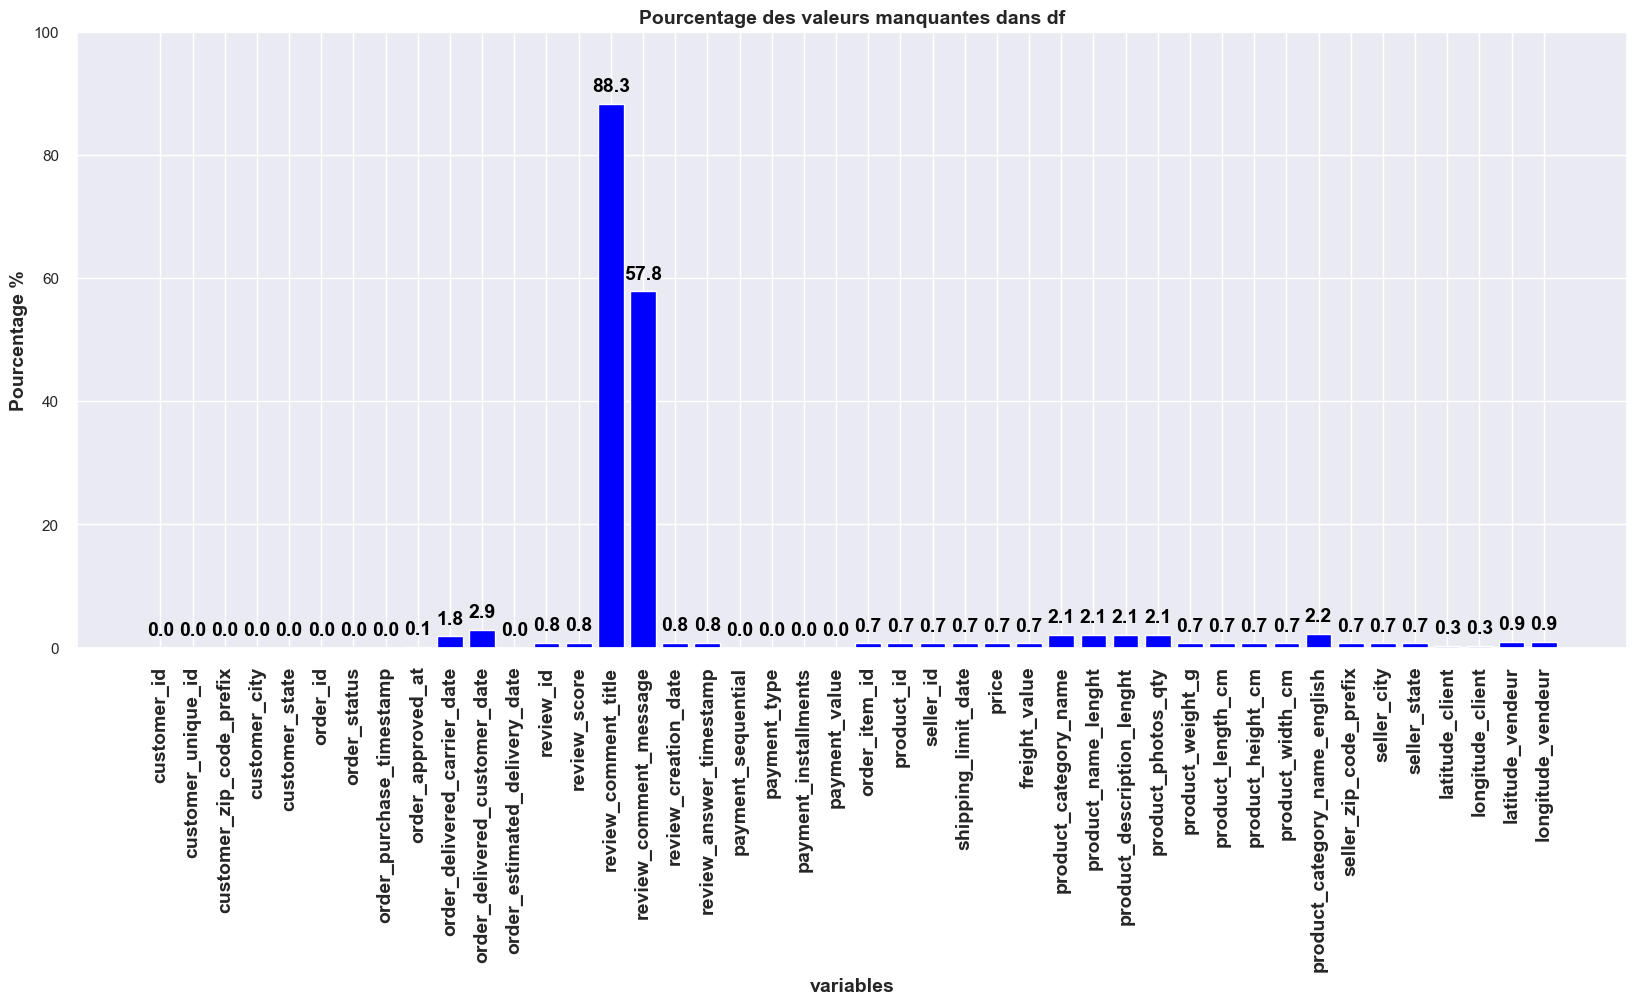

In [44]:
# Représentation graphique du pourcentage des valeurs manquantes pour chaque variable

sns.set_theme()
plt.figure(figsize=(20,8))
df_nan = (df.isna().mean()*100).round(1)
barplot=plt.bar(df_nan.keys(), df_nan.values, color="blue")
plt.bar_label(barplot, labels=df_nan.values, label_type= "edge", 
              weight='bold', padding=6, color= 'black', fontsize=14)
plt.xticks(rotation=90, weight='bold', fontsize=14)
plt.ylim([0,100])
plt.ylabel("Pourcentage %", weight='bold', fontsize=14)
plt.xlabel('variables', weight='bold', fontsize=14)
plt.title('Pourcentage des valeurs manquantes dans df', weight='bold', fontsize=14)
plt.show()

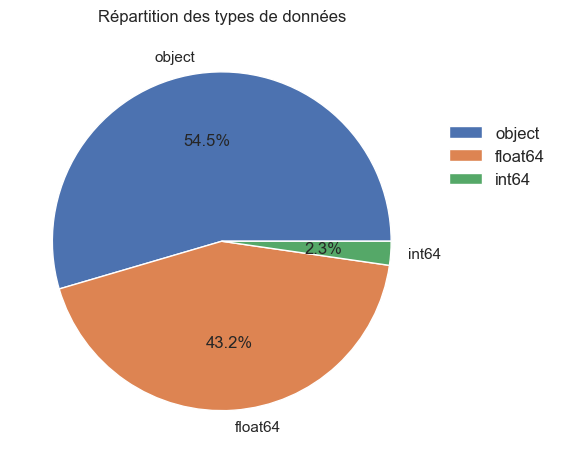

In [45]:
# visualisation de types des données dans le jeu de données

df.dtypes.value_counts().plot(kind='pie', autopct='%1.1f%%', 
                                   title="Répartition des types de données",
                                   legend=False, label="")

ax = plt.gca()
ax.legend(loc="center left",
          fontsize=12,
          bbox_to_anchor=(1, 0.2, 0.5, 1))
sns.set_theme()
plt.show()

In [46]:
df.columns.tolist()

['customer_id',
 'customer_unique_id',
 'customer_zip_code_prefix',
 'customer_city',
 'customer_state',
 'order_id',
 'order_status',
 'order_purchase_timestamp',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'review_id',
 'review_score',
 'review_comment_title',
 'review_comment_message',
 'review_creation_date',
 'review_answer_timestamp',
 'payment_sequential',
 'payment_type',
 'payment_installments',
 'payment_value',
 'order_item_id',
 'product_id',
 'seller_id',
 'shipping_limit_date',
 'price',
 'freight_value',
 'product_category_name',
 'product_name_lenght',
 'product_description_lenght',
 'product_photos_qty',
 'product_weight_g',
 'product_length_cm',
 'product_height_cm',
 'product_width_cm',
 'product_category_name_english',
 'seller_zip_code_prefix',
 'seller_city',
 'seller_state',
 'latitude_client',
 'longitude_client',
 'latitude_vendeur',
 'longitude_vendeur']

#### Rapidité de livraison

On va ajouter une variable 'Rapidité_livraison' qui indique la différence entre la date de livraison prévue et la date de livraison réelle. Une valeur positive pour la variable 'Rapidité_livraison' indique que la livraison a été effectuée en avance par rapport à la date prévue. En revanche, une valeur négative indique un retard de livraison par rapport à la date prévue.

In [47]:
# Convertir les colonnes en objets date ou datetime
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])

# Ajouter une colonne retard_livraison
df['Rapidité_livraison'] = (df['order_estimated_delivery_date'] 
                            - df['order_delivered_customer_date']).dt.days

#### Récence

On va ajouter une variable "récence" qui est calculée en soustrayant la date de la dernière commande d'un client à une date de référence (la date la plus récente de toutes les dernières commandes). Cette différence permet de calculer la durée écoulée depuis la dernière commande passée par le client. La variable "recence" peut être utilisée pour évaluer l'activité et la fidélité des clients au fil du temps.

In [48]:
# Définir la référence : la date la plus récente de toutes les dernières commandes
reference = df['order_purchase_timestamp'].max()
reference

'2018-10-17 17:30:18'

In [49]:
# Convertir les colonnes en objets date ou datetime
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
reference = pd.to_datetime(reference)

# Afficher la date de référence
print("Date de référence: ", reference)

# Calculer la récence pour chaque client et ajouter cette colonne à df
df['récence'] = (reference - df['order_purchase_timestamp']).dt.days


Date de référence:  2018-10-17 17:30:18


In [50]:
# Regroupement par customer_unique_id et agrégations multiples 
df_group = df.groupby('customer_unique_id').agg({
 'customer_id':'nunique',
 'customer_city':'last',
 'customer_state':'last',
 'customer_zip_code_prefix':'last',
 'order_id':['nunique','count'],
 'récence':'mean',
 'Rapidité_livraison':'mean',
 'order_status':'last',
 'review_score':'mean',
 'payment_sequential': 'mean',
 'payment_type':'last',
 'order_purchase_timestamp':['first','last'],
 'payment_installments':'mean',
 'payment_value':'sum',
 'order_item_id':'last',
 'product_id':'last',
 'price':'mean',
 'freight_value':'mean',
 'seller_id': 'last', 
 'seller_zip_code_prefix': 'last', 
 'seller_city':'last',
 'seller_state':'last',
 'latitude_client':'mean',
 'longitude_client':'mean',
 'latitude_vendeur':'mean',
 'longitude_vendeur':'mean'
 })

# Renommer les colonnes du dataframe résultant
df_group.columns = ['_'.join(col).rstrip('_') for col in df_group.columns.values]

# Réinitialiser l'index du dataframe résultant
df_group = df_group.reset_index()


In [51]:
df_group

customer_unique_id  customer_id_nunique  \
0      0000366f3b9a7992bf8c76cfdf3221e2                    1   
1      0000b849f77a49e4a4ce2b2a4ca5be3f                    1   
2      0000f46a3911fa3c0805444483337064                    1   
3      0000f6ccb0745a6a4b88665a16c9f078                    1   
4      0004aac84e0df4da2b147fca70cf8255                    1   
...                                 ...                  ...   
96091  fffcf5a5ff07b0908bd4e2dbc735a684                    1   
96092  fffea47cd6d3cc0a88bd621562a9d061                    1   
96093  ffff371b4d645b6ecea244b27531430a                    1   
96094  ffff5962728ec6157033ef9805bacc48                    1   
96095  ffffd2657e2aad2907e67c3e9daecbeb                    1   

       customer_city_last customer_state_last  customer_zip_code_prefix_last  \
0                 cajamar                  SP                           7787   
1                  osasco                  SP                           6053   
2                sao jose                  SC                          88115   
3                   belem                  PA                          66812   
4                sorocaba                  SP                          18040   
...                   ...                 ...                            ...   
96091             sanharo                  PE                          55250   
96092    feira de santana                  BA                          44054   
96093               sinop                  MT                          78552   
96094  bom jesus do norte                  ES                          29460   
96095         campo largo                  PR                          83608   

       order_id_nunique  order_id_count  récence_mean  \
0                     1               1         160.0   
1                     1               1         163.0   
2                     1               1         585.0   
3                     1               1         369.0   
4                     1               1         336.0   
...                 ...             ...           ...   
96091                 1               2         495.0   
96092                 1               1         310.0   
96093                 1               1         617.0   
96094                 1               1         168.0   
96095                 1               1         532.0   

       Rapidité_livraison_mean order_status_last  ...  price_mean  \
0                          4.0         delivered  ...      129.90   
1                          4.0         delivered  ...       18.90   
2                          1.0         delivered  ...       69.00   
3                         11.0         delivered  ...       25.99   
4                          7.0         delivered  ...      180.00   
...                        ...               ...  ...         ...   
96091                     26.0         delivered  ...      785.00   
96092                      2.0         delivered  ...       64.89   
96093                     29.0         delivered  ...       89.90   
96094                     13.0         delivered  ...      115.00   
96095                     15.0         delivered  ...       56.99   

       freight_value_mean                    seller_id_last  \
0                   12.00  da8622b14eb17ae2831f4ac5b9dab84a   
1                    8.29  138dbe45fc62f1e244378131a6801526   
2                   17.22  3d871de0142ce09b7081e2b9d1733cb1   
3                   17.63  ef506c96320abeedfb894c34db06f478   
4                   16.89  70a12e78e608ac31179aea7f8422044b   
...                   ...                               ...   
96091              248.71  17f51e7198701186712e53a39c564617   
96092               19.69  7aa4334be125fcdd2ba64b3180029f14   
96093               22.56  54aa8463e87776b5612f4bdc4bd5d4de   
96094               18.69  7d13fca15225358621be4086e1eb0964   
96095               14.57  cc419e0650a3c5ba77189a1882b7556a   

      seller_zip_cod

In [52]:
df_group.columns.tolist()

['customer_unique_id',
 'customer_id_nunique',
 'customer_city_last',
 'customer_state_last',
 'customer_zip_code_prefix_last',
 'order_id_nunique',
 'order_id_count',
 'récence_mean',
 'Rapidité_livraison_mean',
 'order_status_last',
 'review_score_mean',
 'payment_sequential_mean',
 'payment_type_last',
 'order_purchase_timestamp_first',
 'order_purchase_timestamp_last',
 'payment_installments_mean',
 'payment_value_sum',
 'order_item_id_last',
 'product_id_last',
 'price_mean',
 'freight_value_mean',
 'seller_id_last',
 'seller_zip_code_prefix_last',
 'seller_city_last',
 'seller_state_last',
 'latitude_client_mean',
 'longitude_client_mean',
 'latitude_vendeur_mean',
 'longitude_vendeur_mean']

In [53]:
# Nombre de lignes et colonnes (taille du jeu de données df_group)

print(f"Nombre de (lignes, colonnes) = {df_group.shape}")

# Nombre des doublons dans le jeu de données df_group

print(f"Nombre des doublons = {df_group.duplicated(keep=False).sum()}")

Nombre de (lignes, colonnes) = (96096, 29)
Nombre des doublons = 0


In [54]:
# Définir et afficher les variables quantitatives et catégorielles 
variables = df_group.columns.tolist()
variables

['customer_unique_id',
 'customer_id_nunique',
 'customer_city_last',
 'customer_state_last',
 'customer_zip_code_prefix_last',
 'order_id_nunique',
 'order_id_count',
 'récence_mean',
 'Rapidité_livraison_mean',
 'order_status_last',
 'review_score_mean',
 'payment_sequential_mean',
 'payment_type_last',
 'order_purchase_timestamp_first',
 'order_purchase_timestamp_last',
 'payment_installments_mean',
 'payment_value_sum',
 'order_item_id_last',
 'product_id_last',
 'price_mean',
 'freight_value_mean',
 'seller_id_last',
 'seller_zip_code_prefix_last',
 'seller_city_last',
 'seller_state_last',
 'latitude_client_mean',
 'longitude_client_mean',
 'latitude_vendeur_mean',
 'longitude_vendeur_mean']

### Variables catégorielles 

In [55]:
# Afficher les variables catégorielles 

variables_catégorielles = df_group.select_dtypes(include=['O']).columns.tolist()
variables_catégorielles

['customer_unique_id',
 'customer_city_last',
 'customer_state_last',
 'order_status_last',
 'payment_type_last',
 'product_id_last',
 'seller_id_last',
 'seller_city_last',
 'seller_state_last']

### Variables quantitatives 

In [56]:
# Afficher les variables quantitatives 
variables_quantitatives = df_group.select_dtypes(exclude=['O']).columns.tolist()
variables_quantitatives

['customer_id_nunique',
 'customer_zip_code_prefix_last',
 'order_id_nunique',
 'order_id_count',
 'récence_mean',
 'Rapidité_livraison_mean',
 'review_score_mean',
 'payment_sequential_mean',
 'order_purchase_timestamp_first',
 'order_purchase_timestamp_last',
 'payment_installments_mean',
 'payment_value_sum',
 'order_item_id_last',
 'price_mean',
 'freight_value_mean',
 'seller_zip_code_prefix_last',
 'latitude_client_mean',
 'longitude_client_mean',
 'latitude_vendeur_mean',
 'longitude_vendeur_mean']

 ### Traitement des valeurs manquantes
  #### Traitement des valeurs manquantes des variables quantitatives

In [57]:
# pourcentage des valeurs manquantes pour chaque variable
df_group.isna().mean()*100

customer_unique_id                0.000000
customer_id_nunique               0.000000
customer_city_last                0.000000
customer_state_last               0.000000
customer_zip_code_prefix_last     0.000000
order_id_nunique                  0.000000
order_id_count                    0.000000
récence_mean                      0.000000
Rapidité_livraison_mean           2.851315
order_status_last                 0.000000
review_score_mean                 0.745088
payment_sequential_mean           0.001041
payment_type_last                 0.001041
order_purchase_timestamp_first    0.000000
order_purchase_timestamp_last     0.000000
payment_installments_mean         0.001041
payment_value_sum                 0.000000
order_item_id_last                0.703463
product_id_last                   0.703463
price_mean                        0.703463
freight_value_mean                0.703463
seller_id_last                    0.703463
seller_zip_code_prefix_last       0.703463
seller_city

In [58]:
# Pour les deux variables de localisation des clients et vendeurs
# Remplacer les valeurs manquantes groupées par catégorie 'customer_city_first' et 'customer_state_first' avec la moyenne

df_group.loc[:, 'latitude_client_mean'] = df_group['latitude_client_mean'].fillna(df_group.groupby('customer_city_last')['latitude_client_mean'].transform('mean'))
df_group.loc[:, 'longitude_client_mean'] = df_group['longitude_client_mean'].fillna(df_group.groupby('customer_city_last')['longitude_client_mean'].transform('mean'))
df_group.loc[:, 'latitude_vendeur_mean'] = df_group['latitude_vendeur_mean'].fillna(df_group.groupby('customer_state_last')['latitude_vendeur_mean'].transform('mean'))
df_group.loc[:, 'longitude_vendeur_mean'] = df_group['longitude_vendeur_mean'].fillna(df_group.groupby('customer_state_last')['longitude_vendeur_mean'].transform('mean'))

# pourcentage des valeurs manquantes pour chaque variable
df_group.isna().mean()*100

customer_unique_id                0.000000
customer_id_nunique               0.000000
customer_city_last                0.000000
customer_state_last               0.000000
customer_zip_code_prefix_last     0.000000
order_id_nunique                  0.000000
order_id_count                    0.000000
récence_mean                      0.000000
Rapidité_livraison_mean           2.851315
order_status_last                 0.000000
review_score_mean                 0.745088
payment_sequential_mean           0.001041
payment_type_last                 0.001041
order_purchase_timestamp_first    0.000000
order_purchase_timestamp_last     0.000000
payment_installments_mean         0.001041
payment_value_sum                 0.000000
order_item_id_last                0.703463
product_id_last                   0.703463
price_mean                        0.703463
freight_value_mean                0.703463
seller_id_last                    0.703463
seller_zip_code_prefix_last       0.703463
seller_city

In [59]:
# Estimation du reste des Nan des variables quantitatives avec KNNImputer
# Modifier la liste variables_quantitatives (supprimer order_purchase_timestamp_first et order_purchase_timestamp_last) 
variables_quantitatives = ['customer_id_nunique',
 'customer_zip_code_prefix_last',
 'order_id_nunique',
 'order_id_count',
 'récence_mean',
 'Rapidité_livraison_mean',
 'review_score_mean',
 'payment_sequential_mean',
 'payment_installments_mean',
 'payment_value_sum',
 'order_item_id_last',
 'price_mean',
 'freight_value_mean',
 'seller_zip_code_prefix_last',
 'latitude_client_mean',
 'longitude_client_mean',
 'latitude_vendeur_mean',
 'longitude_vendeur_mean']
from sklearn.impute import KNNImputer 
imputer = KNNImputer(n_neighbors=5)
df_quantitatives = df_group[variables_quantitatives]
df_group[variables_quantitatives] = imputer.fit_transform(df_quantitatives)

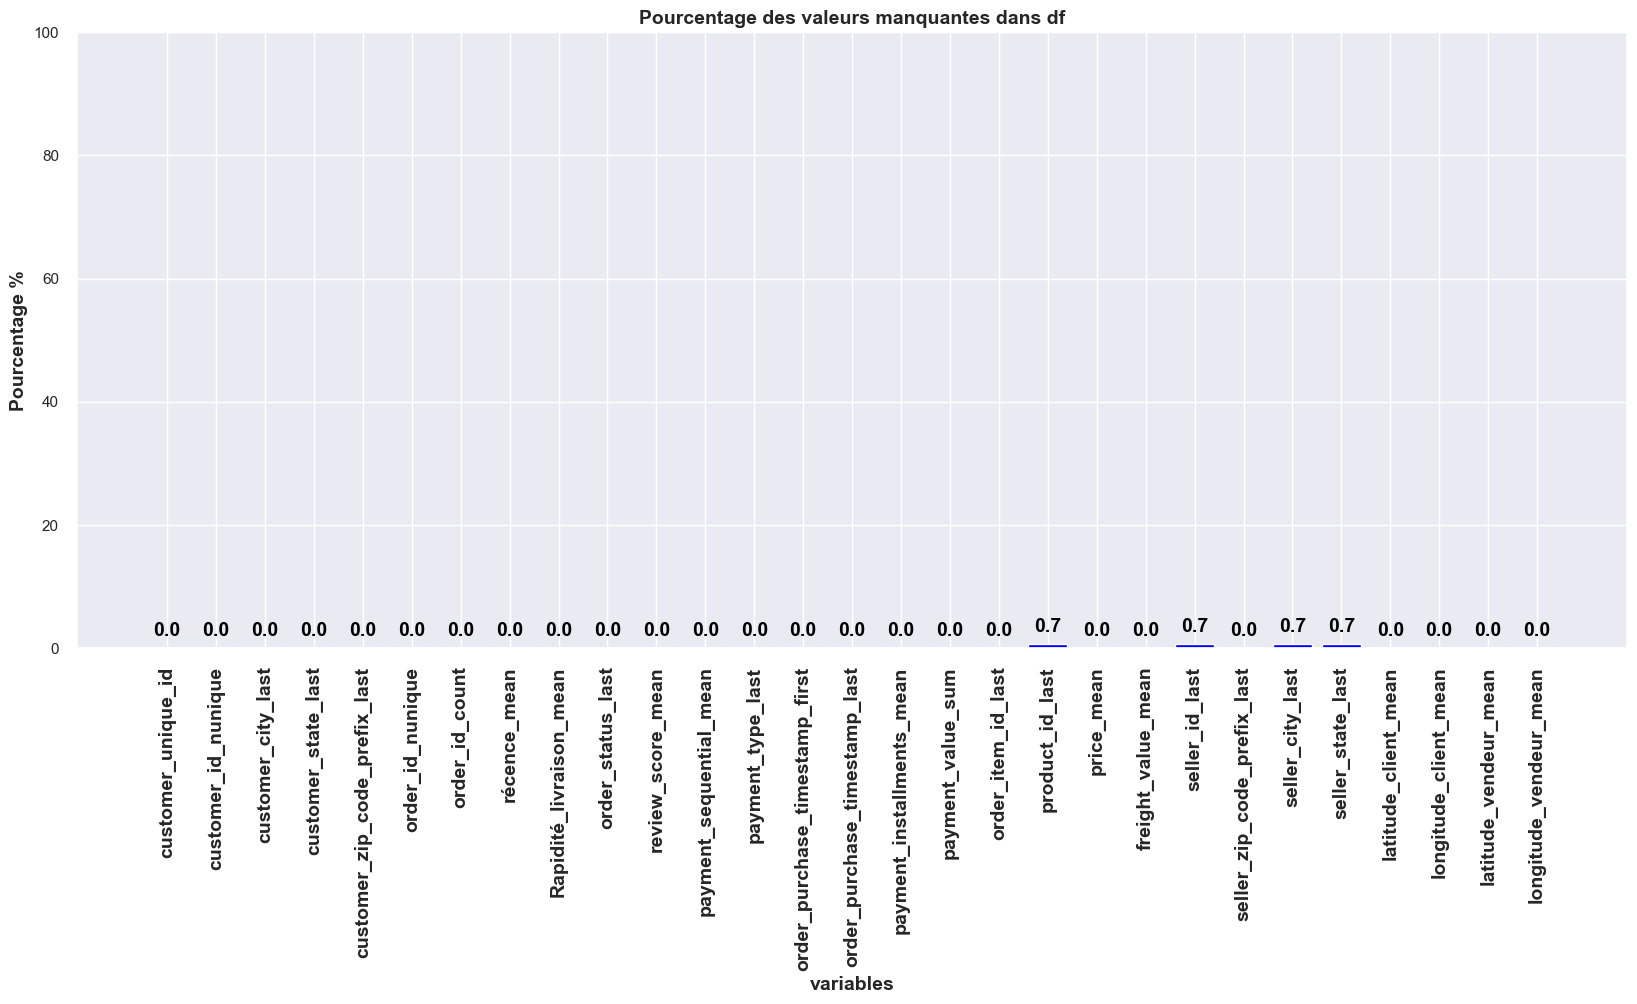

In [60]:
# Représentation graphique du pourcentage des valeurs manquantes pour chaque variable

sns.set_theme()
plt.figure(figsize=(20,8))
df_nan = (df_group.isna().mean()*100).round(1)
barplot=plt.bar(df_nan.keys(), df_nan.values, color="blue")
plt.bar_label(barplot, labels=df_nan.values, label_type= "edge", 
              weight='bold', padding=6, color= 'black', fontsize=14)
plt.xticks(rotation=90, weight='bold', fontsize=14)
plt.ylim([0,100])
plt.ylabel("Pourcentage %", weight='bold', fontsize=14)
plt.xlabel('variables', weight='bold', fontsize=14)
plt.title('Pourcentage des valeurs manquantes dans df', weight='bold', fontsize=14)
plt.show()

  #### Traitement des valeurs manquantes des variables catégorielles

In [61]:
# on va remplacer les valeur NaN des colonnes:
#'product_id_last' par inconnu_id
# 'seller_city_last' par inconnu
# 'seller_id_last' par inconnu
# 'seller_state_last' par inconnu

df_group.loc[:, 'product_id_last']= df_group['product_id_last'].fillna('inconnu_id')
df_group.loc[:, 'seller_city_last']= df_group['seller_city_last'].fillna('inconnu')
df_group.loc[:, 'seller_state_last']= df_group['seller_state_last'].fillna('inconnu')
df_group.loc[:, 'seller_id_last']= df_group['seller_id_last'].fillna('inconnu')

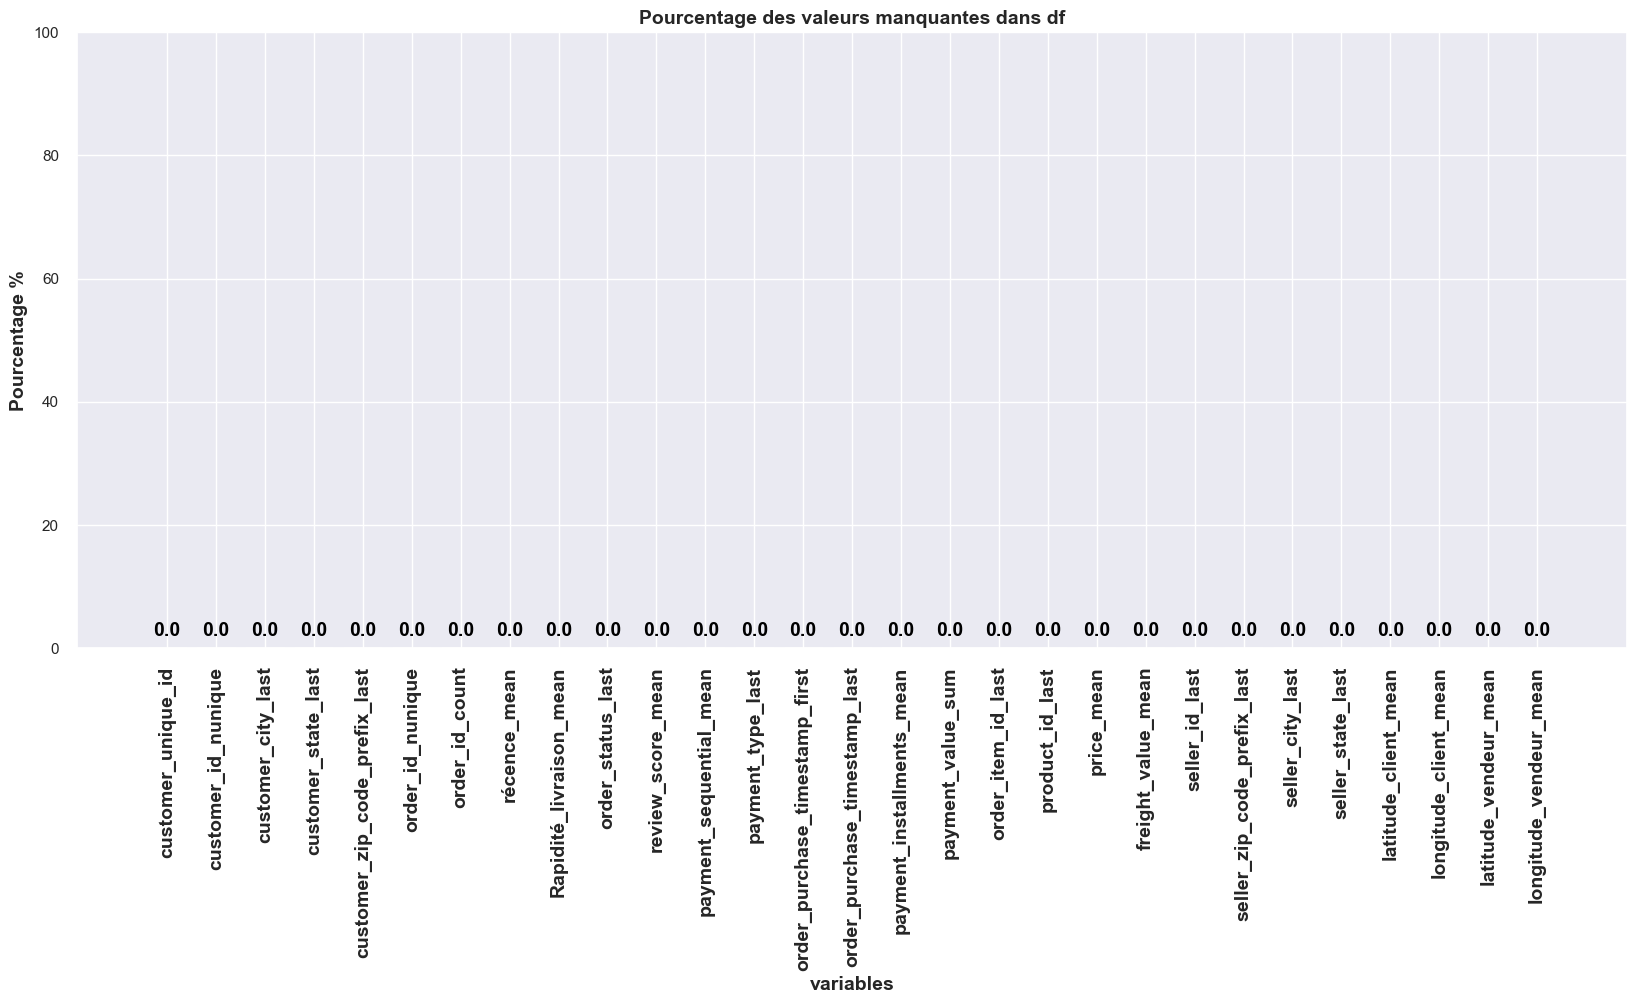

In [62]:
# Représentation graphique du pourcentage des valeurs manquantes pour chaque variable

sns.set_theme()
plt.figure(figsize=(20,8))
df_nan = (df_group.isna().mean()*100).round(1)
barplot=plt.bar(df_nan.keys(), df_nan.values, color="blue")
plt.bar_label(barplot, labels=df_nan.values, label_type= "edge", 
              weight='bold', padding=6, color= 'black', fontsize=14)
plt.xticks(rotation=90, weight='bold', fontsize=14)
plt.ylim([0,100])
plt.ylabel("Pourcentage %", weight='bold', fontsize=14)
plt.xlabel('variables', weight='bold', fontsize=14)
plt.title('Pourcentage des valeurs manquantes dans df', weight='bold', fontsize=14)
plt.show()

In [63]:
df_group.columns.tolist()

['customer_unique_id',
 'customer_id_nunique',
 'customer_city_last',
 'customer_state_last',
 'customer_zip_code_prefix_last',
 'order_id_nunique',
 'order_id_count',
 'récence_mean',
 'Rapidité_livraison_mean',
 'order_status_last',
 'review_score_mean',
 'payment_sequential_mean',
 'payment_type_last',
 'order_purchase_timestamp_first',
 'order_purchase_timestamp_last',
 'payment_installments_mean',
 'payment_value_sum',
 'order_item_id_last',
 'product_id_last',
 'price_mean',
 'freight_value_mean',
 'seller_id_last',
 'seller_zip_code_prefix_last',
 'seller_city_last',
 'seller_state_last',
 'latitude_client_mean',
 'longitude_client_mean',
 'latitude_vendeur_mean',
 'longitude_vendeur_mean']

In [64]:
# Nombre de lignes et colonnes (taille du jeu de données df_group)

print(f"Nombre de (lignes, colonnes) = {df_group.shape}")

# Nombre des doublons dans le jeu de données df_group

print(f"Nombre des doublons = {df_group.duplicated(keep=False).sum()}")

Nombre de (lignes, colonnes) = (96096, 29)
Nombre des doublons = 0


## I) Analyse exploratoire

### La variable "récence_mean"

In [65]:
df_group['récence_mean'].describe()

count    96096.000000
mean       289.097044
std        153.145297
min          0.000000
25%        165.000000
50%        271.000000
75%        398.000000
max        772.000000
Name: récence_mean, dtype: float64

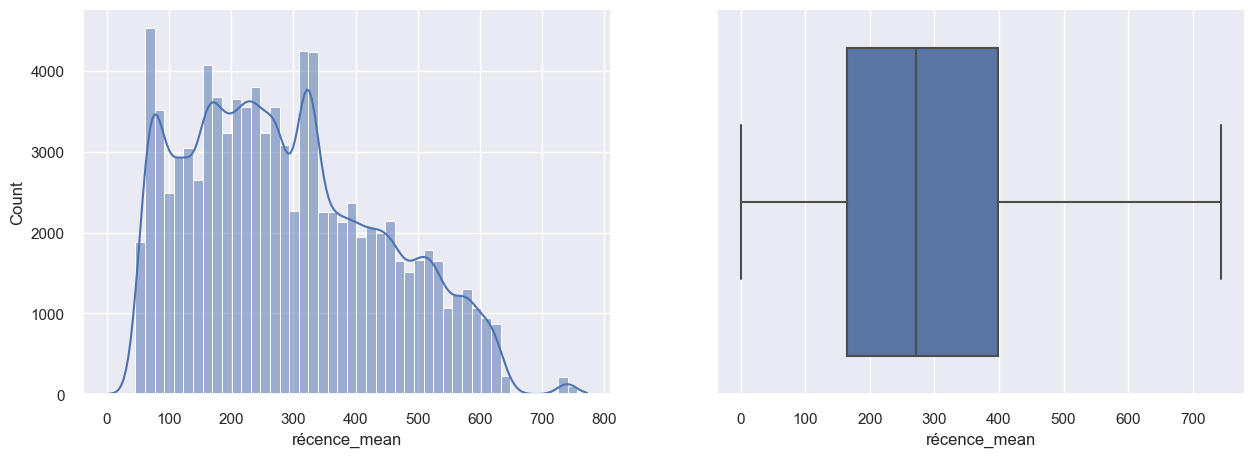

In [66]:
# Distribution de la variable "recence" avec displot et boxplot
sns.set_theme()
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
sns.histplot(data=df_group, x="récence_mean", kde=True, bins=50, ax=ax1)
sns.boxplot(data=df_group, x="récence_mean", ax=ax2, showfliers=False)
plt.show()


Les statistiques descriptives de la variable "récence_mean" montre que la moyenne de la variable est de 289 avec un écart-type de 153. La valeur minimale est de 0 et la valeur maximale est de 772. Les quartiles de la variable sont de 165 (25ème percentile), 271 (50ème percentile) et 398 (75ème percentile).

Cela peut suggérer que la majorité des clients n'ont pas effectué d'achats depuis très longtemps et que l'entreprise pourrait avoir besoin de mettre en place des stratégies pour les inciter à effectuer des achats plus fréquents.


### seller_zip_code_prefix_last

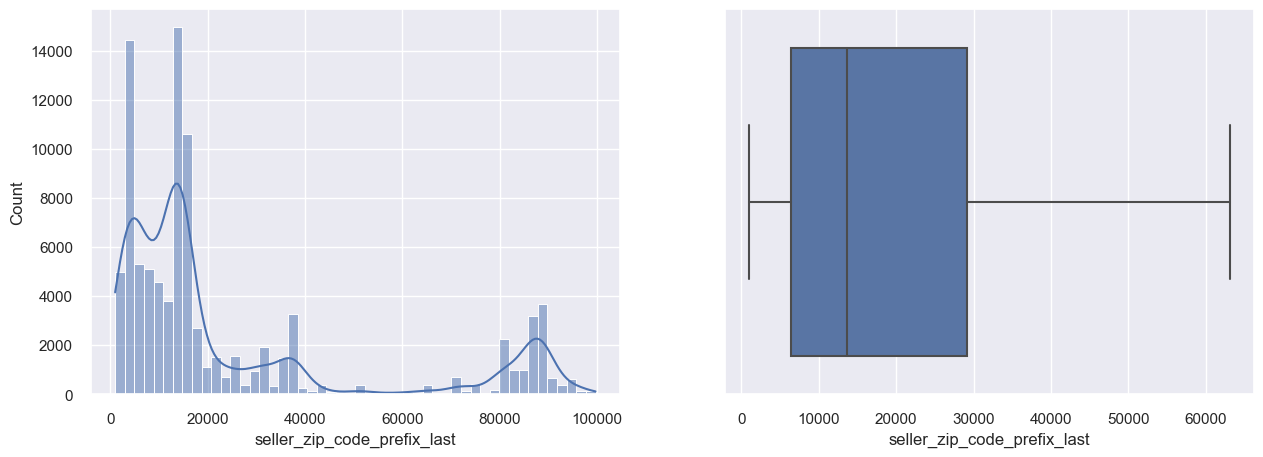

__________________________________________
seller_zip_code_prefix_last
__________________________________________
count    96096.000000
mean     24631.721148
std      27627.838845
min       1001.000000
25%       6455.000000
50%      13601.000000
75%      29156.000000
max      99730.000000
Name: seller_zip_code_prefix_last, dtype: float64
__________________________________________


In [67]:
# Distribution de la variable seller_zip_code_prefix_last avec displot et boxplot
sns.set_theme()
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
sns.histplot(data=df_group, x="seller_zip_code_prefix_last", kde=True, bins=50, ax=ax1)
sns.boxplot(data=df_group, x="seller_zip_code_prefix_last", ax=ax2, showfliers=False)
plt.show()

print('_'*42)
print('seller_zip_code_prefix_last')
print('_'*42)
print(df_group['seller_zip_code_prefix_last'].describe())
print('_'*42)

### La variable 'Rapidité_livraison_mean'

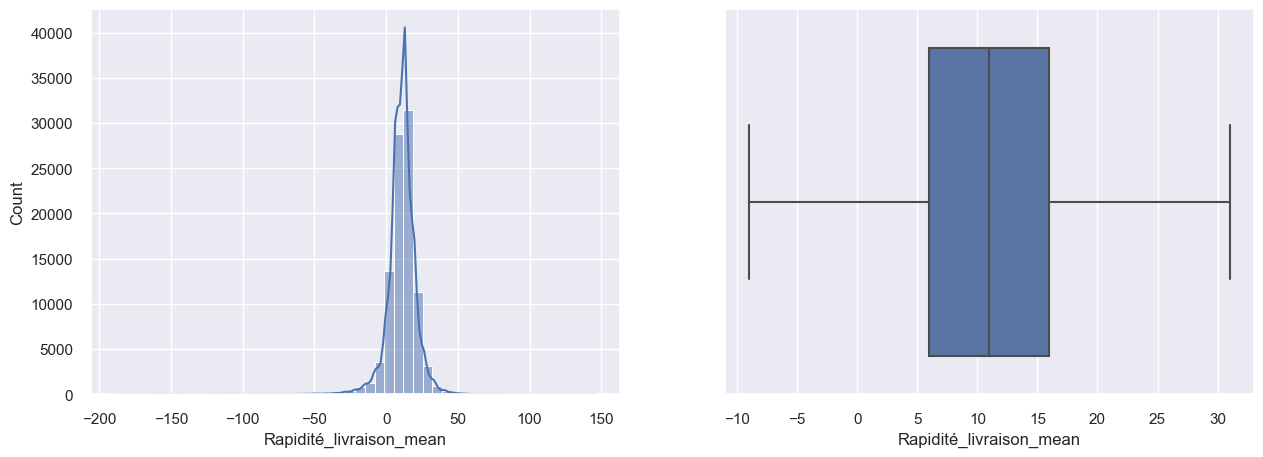

__________________________________________
Rapidité_livraison_mean
__________________________________________
count    96096.000000
mean        10.837854
std         10.041629
min       -189.000000
25%          6.000000
50%         11.000000
75%         16.000000
max        146.000000
Name: Rapidité_livraison_mean, dtype: float64
__________________________________________


In [68]:
# Distribution de la variable 'retard_livraison_mean' avec displot et boxplot
sns.set_theme()
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
sns.histplot(data=df_group, x='Rapidité_livraison_mean', kde=True, bins=50, ax=ax1)
sns.boxplot(data=df_group, x='Rapidité_livraison_mean', ax=ax2, showfliers=False)
plt.show()

print('_'*42)
print('Rapidité_livraison_mean')
print('_'*42)
print(df_group['Rapidité_livraison_mean'].describe())
print('_'*42)

La distribution des données de la rapidité de livraison montre une moyenne de 10.84 avec une déviation standard de 10.04. Les valeurs négatives représentent le retard de livraison et la valeur minimale est de -189 (retard de livraison). Les quartiles (25%, 50%, 75%) sont respectivement de 6, 11 et 16, et la valeur maximale est de 146, ce qui est relativement élevé par rapport à la moyenne et aux quartiles. Il serait nécessaire de poursuivre l'analyse pour comprendre pourquoi il y a une telle variabilité dans la rapidité de livraison et prendre des mesures pour améliorer les performances de l'entreprise si nécessaire.

 ### Les variables de localisation des clients/vendeurs: 
 ### 'latitude_client_mean' , 'longitude_client_mean', 
 ### 'latitude_vendeur_mean' , 'longitude_vendeur_mean'

In [69]:
# Récupérer les résultats des deux codes
print('_'*42)
print('latitude_client_mean')
print('_'*42)
print(df_group['latitude_client_mean'].describe())
print('_'*42)
print('_'*42)
print('longitude_client_mean')
print('_'*42)
print(df_group['longitude_client_mean'].describe())
print('_'*42)

__________________________________________
latitude_client_mean
__________________________________________
count    96096.000000
mean       -21.165915
std          5.624687
min        -33.689948
25%        -23.588457
50%        -22.922759
75%        -20.076514
max         42.184003
Name: latitude_client_mean, dtype: float64
__________________________________________
__________________________________________
longitude_client_mean
__________________________________________
count    96096.000000
mean       -46.174759
std          4.057901
min        -72.668881
25%        -48.104959
50%        -46.631466
75%        -43.598897
max         -8.723762
Name: longitude_client_mean, dtype: float64
__________________________________________


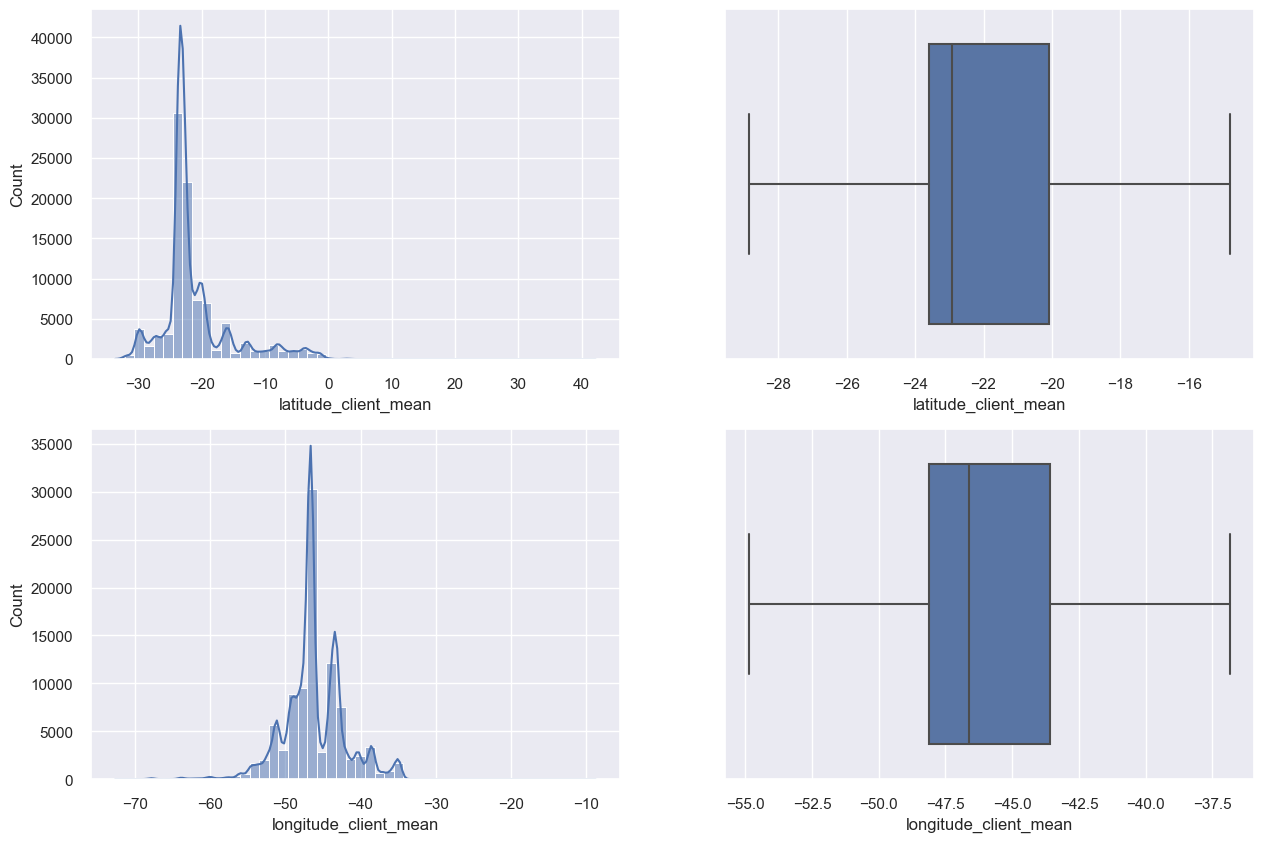

In [70]:
# Distribution des deux variables geolocation_lat_last et geolocation_lng_last avec displot et boxplot
sns.set_theme()
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))

# Afficher la distribution de geolocation_lat_last
sns.histplot(data=df_group, x='latitude_client_mean', kde=True, bins=50, ax=axs[0, 0])
sns.boxplot(data=df_group, x='latitude_client_mean', ax=axs[0, 1], showfliers=False)

# Afficher la distribution de geolocation_lng_last
sns.histplot(data=df_group, x='longitude_client_mean', kde=True, bins=50, ax=axs[1, 0])
sns.boxplot(data=df_group, x='longitude_client_mean', ax=axs[1, 1], showfliers=False)

plt.show()




In [71]:
# Récupérer les résultats des deux codes
print('_'*42)
print('latitude_vendeur_mean')
print('_'*42)
print(df_group['latitude_vendeur_mean'].describe())
print('_'*42)
print('_'*42)
print('longitude_vendeur_mean')
print('_'*42)
print(df_group['longitude_vendeur_mean'].describe())
print('_'*42)

__________________________________________
latitude_vendeur_mean
__________________________________________
count    96096.000000
mean       -22.791976
std          2.726943
min        -32.079231
25%        -23.610141
50%        -23.410633
75%        -21.796803
max         -2.501242
Name: latitude_vendeur_mean, dtype: float64
__________________________________________
__________________________________________
longitude_vendeur_mean
__________________________________________
count    96096.000000
mean       -47.216269
std          2.326058
min        -67.813284
25%        -48.623442
50%        -46.755753
75%        -46.522287
max        -34.855616
Name: longitude_vendeur_mean, dtype: float64
__________________________________________


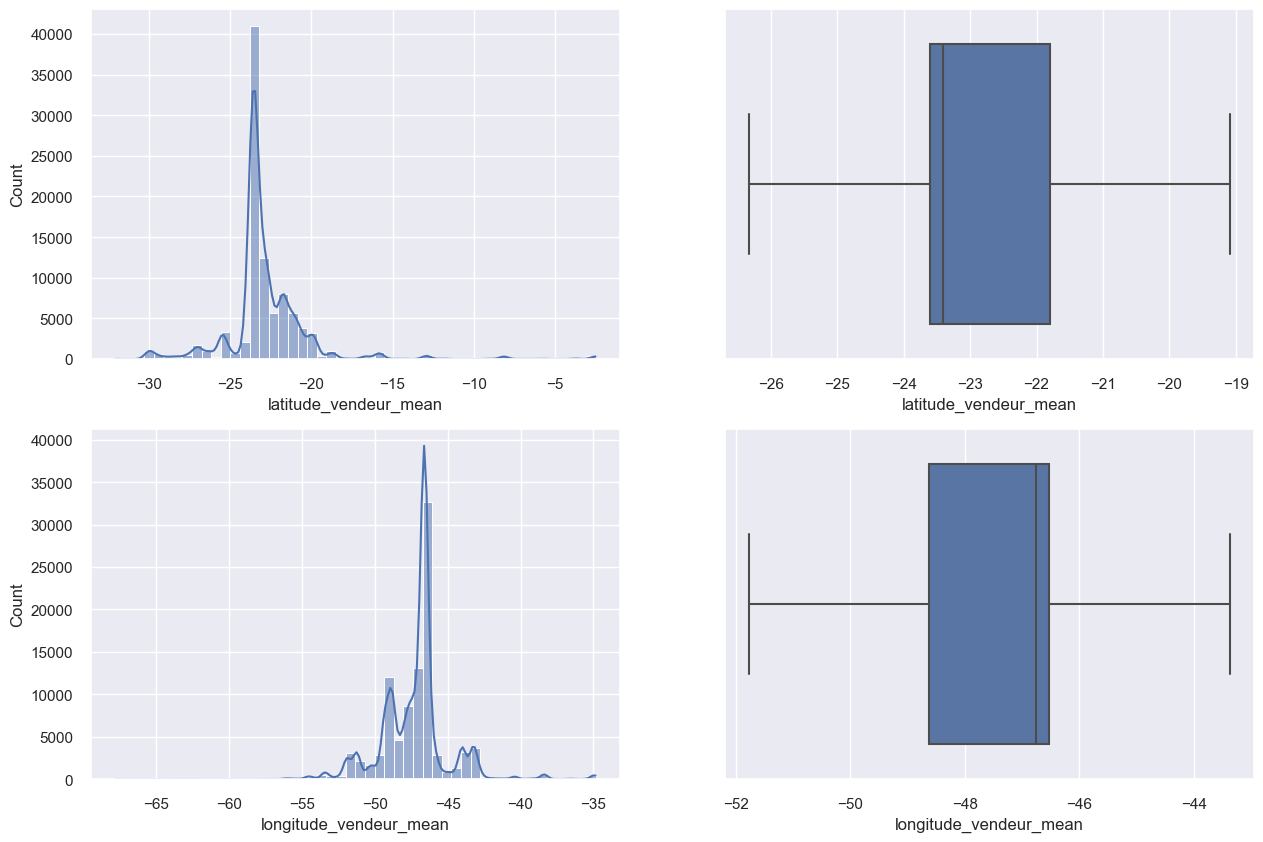

In [72]:
# Distribution des deux variables geolocation_lat_last et geolocation_lng_last avec displot et boxplot
sns.set_theme()
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))

# Afficher la distribution de geolocation_lat_last
sns.histplot(data=df_group, x='latitude_vendeur_mean', kde=True, bins=50, ax=axs[0, 0])
sns.boxplot(data=df_group, x='latitude_vendeur_mean', ax=axs[0, 1], showfliers=False)

# Afficher la distribution de geolocation_lng_last
sns.histplot(data=df_group, x='longitude_vendeur_mean', kde=True, bins=50, ax=axs[1, 0])
sns.boxplot(data=df_group, x='longitude_vendeur_mean', ax=axs[1, 1], showfliers=False)

plt.show()


### Localisation des clients et des vendeurs avec Folium

In [73]:
# Localisation des clients avec folium
import folium
from folium import plugins
Géolocalisation = [-23.499063, -46.767939]
localisation  = folium.Map(location=Géolocalisation,zoom_start=4)
# Échantillonner de manière aléatoire 500 lignes du dataframe df_group.
# L'affichage de la carte prend beaucoup du temps avec l'intégralité de df_group.
df_group_reduit = df_group.sample(n=500, random_state=0)
for x in range(0,500):
    folium.Marker([df_group_reduit.iloc[x]['latitude_client_mean'],df_group_reduit.iloc[x]['longitude_client_mean']], 
                      popup=df_group_reduit.iloc[x]['customer_unique_id']).add_to(localisation)
localisation

In [74]:

# Localisation initiale
Géolocalisation = [-23.499063, -46.767939]

# Création de la carte
localisation = folium.Map(location=Géolocalisation, zoom_start=4)

# Échantillonnage aléatoire de 500 lignes du dataframe df_group pour améliorer les performances d'affichage.
df_group_reduit = df_group.sample(n=500, random_state=0)

# Ajout des marqueurs pour les clients et les vendeurs
for x in range(0,500):
    if df_group_reduit.iloc[x]['seller_id_last']:
        # Ajout de marqueurs pour les vendeurs en rouge
        folium.Marker([df_group_reduit.iloc[x]['latitude_vendeur_mean'], df_group_reduit.iloc[x]['longitude_vendeur_mean']],
                      popup=df_group_reduit.iloc[x]['seller_id_last'], icon=folium.Icon(color='red')).add_to(localisation)
    if df_group_reduit.iloc[x]['customer_unique_id']:
        # Ajout de marqueurs pour les clients en bleu
        folium.Marker([df_group_reduit.iloc[x]['latitude_client_mean'], df_group_reduit.iloc[x]['longitude_client_mean']],
                      popup=df_group_reduit.iloc[x]['customer_unique_id'], icon=folium.Icon(color='blue')).add_to(localisation)

# Affichage de la carte
localisation


En utilisant Folium, nous avons pu localiser les clients sur une carte en spécifiant des coordonnées de latitude et de longitude. Des marqueurs ont ensuite été ajoutés pour les clients et les vendeurs. Nous avons également effectué un échantillonnage aléatoire de 500 lignes du dataframe pour améliorer les performances d'affichage. Les marqueurs pour les vendeurs sont affichés en rouge, tandis que ceux pour les clients sont affichés en bleu.


### Type de paiement

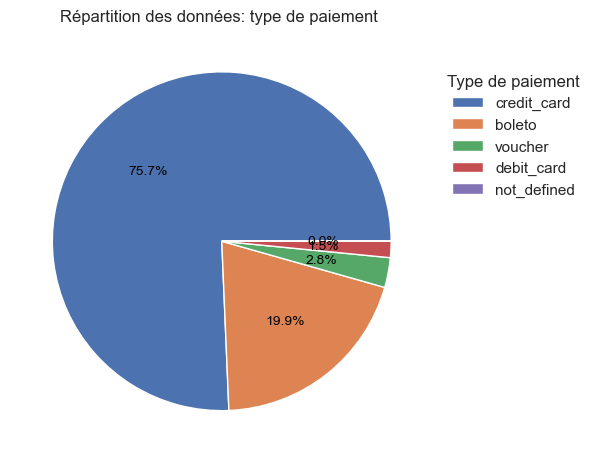

In [75]:
# Répartition des données de la variable payment_type
plt.title('Répartition des données: type de paiement ', size=12)
wedges, texts, autotexts = plt.pie(df_group['payment_type_last'].value_counts(),
                                   autopct='%1.1f%%', textprops={'fontsize': 10, 
                                     'color' : 'Black'})
    
ax = plt.gca()
sns.set_theme()
ax.legend(wedges, df_group['payment_type_last'].unique(),
          title='Type de paiement',
          loc="center left",
          fontsize=11,
          bbox_to_anchor=(1, 0, 1, 1.5))
plt.show()

D'après la répartition des données, il est clair que la carte de crédit est le mode de paiement le plus couramment utilisé, représentant 76% des transactions. Cela souligne l'importance de faciliter l'utilisation de ce mode de paiement pour améliorer l'expérience client et augmenter les ventes. Bien que d'autres modes de paiement tels que les bolets(le bolet est un mode de paiement utilisé principalement au Brésil. Il s'agit d'un bon de paiement émis par une banque ou une entreprise), les vouchers et les cartes de débit soient également disponibles, leur utilisation est moins fréquente.

Il serait donc intéressant de comprendre pourquoi les clients préfèrent la carte de crédit par rapport à d'autres options de paiement et s'il existe des obstacles qui empêchent les clients d'utiliser d'autres modes de paiement. De telles informations pourraient aider à améliorer les options de paiement disponibles pour les clients et à augmenter la satisfaction globale des clients.

In [76]:
# statistiques descriptives et transposer le tableau avec l'attribut T 
df_group.describe().T

count          mean           std  \
customer_id_nunique            96096.0      1.034809      0.214384   
customer_zip_code_prefix_last  96096.0  35184.412463  29800.101792   
order_id_nunique               96096.0      1.034809      0.214384   
order_id_count                 96096.0      1.239833      0.853158   
récence_mean                   96096.0    289.097044    153.145297   
Rapidité_livraison_mean        96096.0     10.837854     10.041629   
review_score_mean              96096.0      4.078993      1.340738   
payment_sequential_mean        96096.0      1.023112      0.191591   
payment_installments_mean      96096.0      2.902386      2.678868   
payment_value_sum              96096.0    214.157343    644.891987   
order_item_id_last             96096.0      1.139750      0.532597   
price_mean                     96096.0    126.523232    191.489271   
freight_value_mean             96096.0     20.219942     15.789523   
seller_zip_code_prefix_last    96096.0  24631.721148  27627.838845   
latitude_client_mean           96096.0    -21.165915      5.624687   
longitude_client_mean          96096.0    -46.174759      4.057901   
latitude_vendeur_mean          96096.0    -22.791976      2.726943   
longitude_vendeur_mean         96096.0    -47.216269      2.326058   

                                       min           25%           50%  \
customer_id_nunique               1.000000      1.000000      1.000000   
customer_zip_code_prefix_last  1003.000000  11390.000000  24440.000000   
order_id_nunique                  1.000000      1.000000      1.000000   
order_id_count                    1.000000      1.000000      1.000000   
récence_mean                      0.000000    165.000000    271.000000   
Rapidité_livraison_mean        -189.000000      6.000000     11.000000   
review_score_mean                 1.000000      4.000000      5.000000   
payment_sequential_mean           1.000000      1.000000      1.000000   
payment_installments_mean         0.000000      1.000000      2.000000   
payment_value_sum                 0.000000     64.000000    113.340000   
order_item_id_last                1.000000      1.000000      1.000000   
price_mean                        0.850000     42.900000     79.205000   
freight_value_mean                0.000000     13.370000     16.400000   
seller_zip_code_prefix_last    1001.000000   6455.000000  13601.000000   
latitude_client_mean            -33.689948    -23.588457    -22.922759   
longitude_client_mean           -72.668881    -48.104959    -46.631466   
latitude_vendeur_mean           -32.079231    -23.610141    -23.410633   
longitude_vendeur_mean          -67.813284    -48.623442    -46.755753   

                                        75%            max  
customer_id_nunique                1.000000      17.000000  
customer_zip_code_prefix_last  59032.750000   99990.000000  
order_id_nunique                   1.000000      17.000000  
order_id_count                     1.000000      75.000000  
récence_mean                     398.000000     772.000000  
Rapidité_livraison_mean           16.000000     146.000000  
review_score_mean                  5.000000       5.000000  
payment_sequential_mean            1.000000      15.000000  
payment_installments_mean          4.000000      24.000000  
payment_value_sum                203.422500  109312.640000  
order_item_id_last                 1.000000      21.000000  
price_mean                       139.900000    6735.000000  
freight_value_mean                21.220000     409.680000  
seller_zip_code_prefix_last    29156.000000   99730.000000  
latitude_client_mean             -20.076514      42.184003  
longitude_client_mean            -43.598897      -8.723762  
latitude_vendeur_mean            -21.796803      -2.501242  
longitude_vendeur_mean           -46.522287     -34.855616

### payment_value_sum : courbe de Lorenz pour les paiements par client

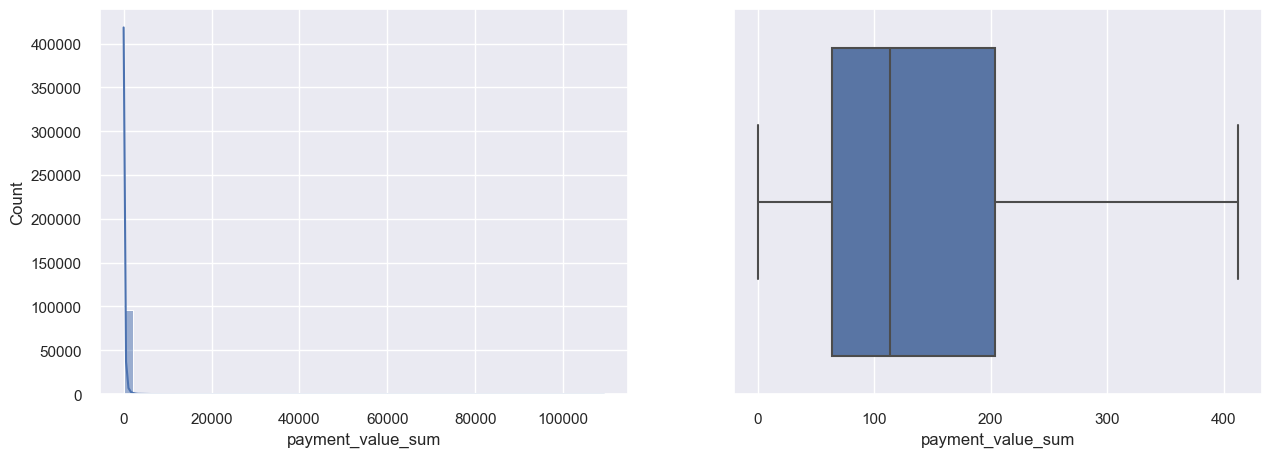

__________________________________________
payment_value_sum
__________________________________________
count     96096.000000
mean        214.157343
std         644.891987
min           0.000000
25%          64.000000
50%         113.340000
75%         203.422500
max      109312.640000
Name: payment_value_sum, dtype: float64
__________________________________________


In [77]:
# Distribution de la variable payment_value_sum avec displot et boxplot
sns.set_theme()
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
sns.histplot(data=df_group, x="payment_value_sum", kde=True, bins=50, ax=ax1)
sns.boxplot(data=df_group, x="payment_value_sum", ax=ax2, showfliers=False)
plt.show()

print('_'*42)
print('payment_value_sum')
print('_'*42)
print(df_group['payment_value_sum'].describe())
print('_'*42)

### Courbe de Lorenz pour les paiements par client 

La courbe de Lorenz pour les paiements par client permet de visualiser la répartition des paiements effectués par les différents clients. Elle indique la part cumulée de paiements effectués en fonction de la part cumulée de clients.

Si la courbe de Lorenz est proche de la diagonale, cela indique une distribution égale des paiements entre tous les clients. Si la courbe est en dessous de la diagonale, cela signifie que les paiements sont concentrés sur un petit nombre de clients, ce qui peut affecter la rentabilité de l'entreprise si ces clients à forte valeur sont perdus.

À l'inverse, si la courbe est au-dessus de la diagonale, cela indique que les paiements sont répartis de manière plus égale entre les clients, ce qui peut être bénéfique pour la rentabilité à long terme de l'entreprise.

En analysant la courbe de Lorenz pour les paiements par client, on peut donc identifier les clients à forte valeur et adapter les stratégies de marketing et de vente en conséquence pour maximiser la rentabilité de l'entreprise.

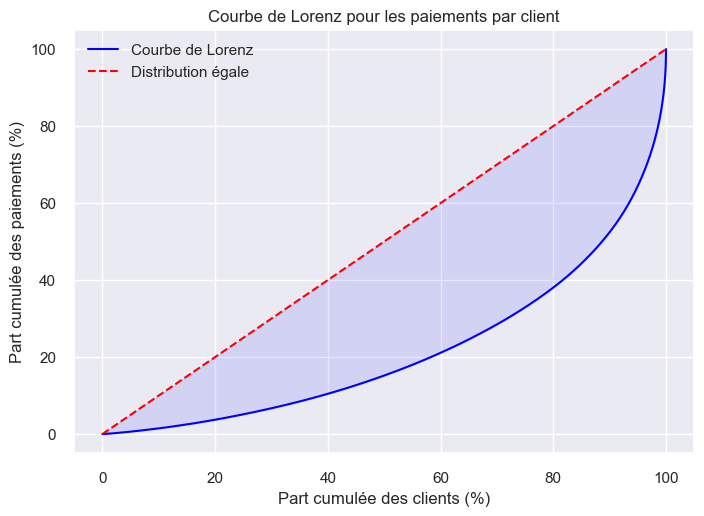

In [78]:
# Calculer le cumul des paiements pour chaque client
df_cumsum = df_group.sort_values('payment_value_sum')['payment_value_sum'].cumsum()

# Calculer la somme totale des paiements
total_payments = df_group['payment_value_sum'].sum()

# Calculer la part cumulée de la somme totale des paiements pour chaque client
part_cumulée = df_cumsum / total_payments * 100

# Ajouter les points (0,0) et (100,100) à la courbe de Lorenz
part_cumulée = pd.Series([0] + part_cumulée.tolist() + [100])
xaxis = np.linspace(0,100,len(part_cumulée))

# Tracer la courbe de Lorenz
plt.plot(xaxis, part_cumulée, color='blue', label='Courbe de Lorenz')
plt.plot([0,100], [0,100], linestyle='--', color='red', label='Distribution égale')

# Calculer l'aire sous la courbe de Lorenz
aire_lorenz = np.trapz(part_cumulée, xaxis)

# Calculer l'aire totale sous la distribution égale
aire_totale = (xaxis[-1] * xaxis[-1]) / 2

# Calculer l'indice de Gini
gini_index = 1 - (2 * aire_lorenz / aire_totale)

# Ajouter la légende 
plt.title(f'Courbe de Lorenz pour les paiements par client')
plt.xlabel('Part cumulée des clients (%)')
plt.ylabel('Part cumulée des paiements (%)')
plt.legend()

# Colorer les aires
plt.fill_between(xaxis, part_cumulée, xaxis, color='blue', alpha=0.1)

sns.set_theme()
plt.show()


On peut constater que 80% de la part cumulée des clients ne représentent que 40% de la part cumulée des paiements, ce qui peut indiquer une grande disparité dans les montants dépensés par les clients. En effet, cela peut suggérer que certains clients effectuent des achats de grande valeur, tandis que d'autres effectuent des achats de faible valeur. Cette disparité peut avoir un impact significatif sur la rentabilité globale de l'entreprise. En comprenant mieux la structure de la clientèle, il est possible de développer des stratégies de marketing et de vente plus efficaces pour différents segments de clients. Ces informations peuvent aider l'entreprise à mieux cibler ses efforts de marketing et de vente, en se concentrant sur les segments de clients les plus rentables.

Si une grande partie des paiements provient d'un petit groupe de clients à forte valeur, la perte de ces clients pourrait avoir un impact important sur les bénéfices de l'entreprise. De même, si l'entreprise peut identifier ces clients à forte valeur et leur proposer des offres spéciales ou des avantages supplémentaires, cela peut stimuler leur engagement et leur fidélité à l'entreprise, ce qui peut avoir un impact positif sur la rentabilité à long terme.

### price_mean (prix moyen de l'article) et freight_value_mean' (coût de livraison moyen) 

In [79]:
# Définir une nouvelle variable : pourcentage de frais de livraison par rapport au prix
df_group['%_frais_livraison'] = df_group['freight_value_mean'] / df_group['price_mean'] * 100

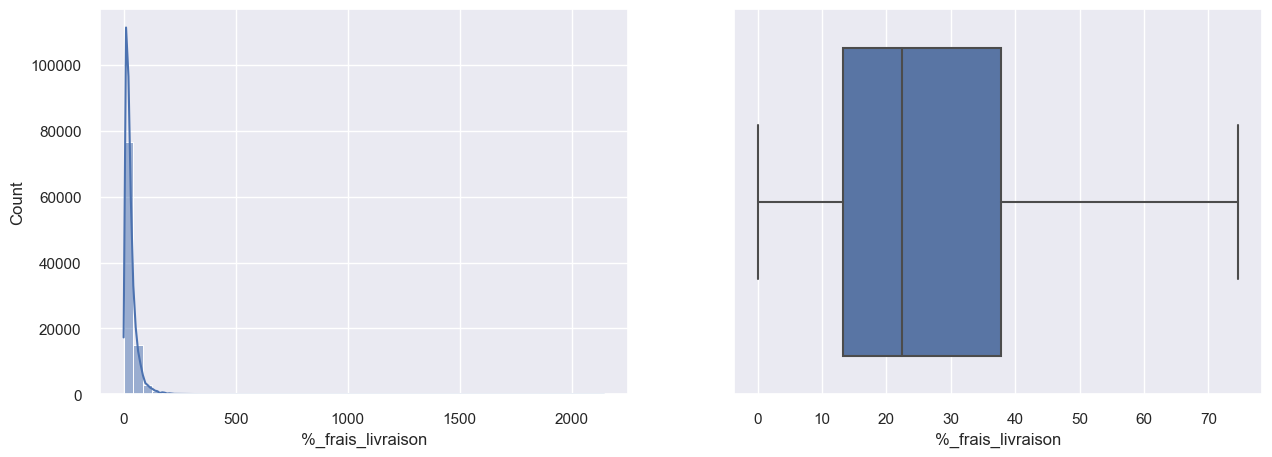

__________________________________________
pourcentage de frais de livraison par rapport au prix
__________________________________________
count    96096.000000
mean        30.569526
std         30.872931
min          0.000000
25%         13.176239
50%         22.380423
75%         37.759440
max       2144.705882
Name: %_frais_livraison, dtype: float64
__________________________________________


In [80]:
# Distribution de la variable pourcentage_livraison avec displot et boxplot
sns.set_theme()
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
sns.histplot(data=df_group, x="%_frais_livraison", kde=True, bins=50, ax=ax1)
sns.boxplot(data=df_group, x="%_frais_livraison", ax=ax2, showfliers=False)
plt.show()

print('_'*42)
print('pourcentage de frais de livraison par rapport au prix')
print('_'*42)
print(df_group['%_frais_livraison'].describe())
print('_'*42)

La distribution de la variable "%_frais_livraison" montre une moyenne de 30.57% avec une déviation standard de 30.87%. La valeur minimale est de 0% tandis que le quartile inférieur (25%) est de 13.18% et le médian (50%) est de 22.38%. Le quartile supérieur (75%) est de 37.76%, ce qui indique que la majorité des frais de livraison représentent moins de 38% du prix total. Cependant, la valeur maximale est de 2144 %.

En théorie, le pourcentage de frais de livraison peut dépasser 100% si le coût de livraison est supérieur au prix de l'article lui-même. Cependant, dans la plupart des cas, il serait probablement considéré comme une valeur extrême. Il serait judicieux de le remplacer les valeurs supérieures à 100% par 100 peut être une solution de facilité.

In [81]:
# remplacer les valeurs extrême (>100 %) par 100
df_group.loc[df_group['%_frais_livraison'] > 100, '%_frais_livraison'] = 100

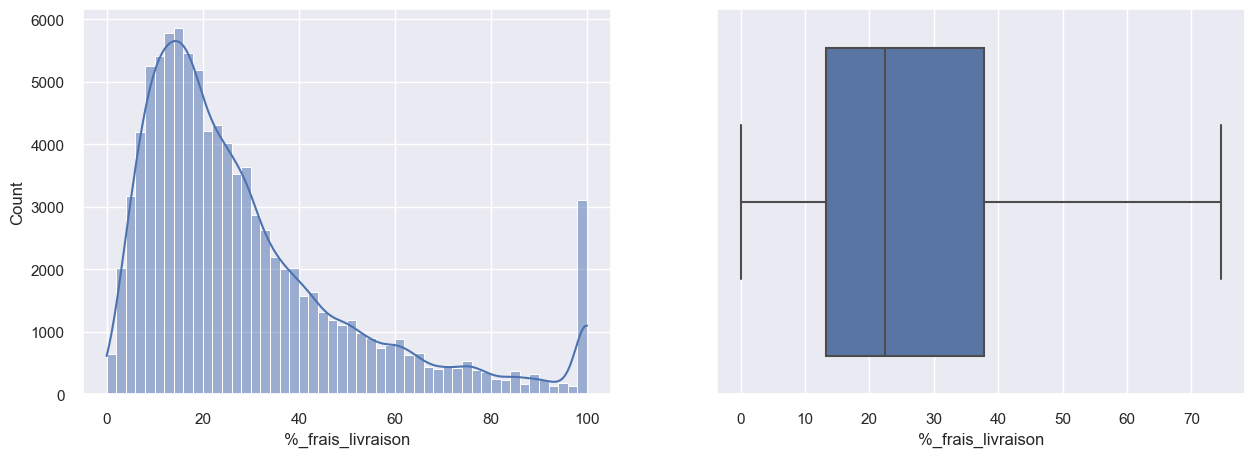

__________________________________________
pourcentage de frais de livraison par rapport au prix
__________________________________________
count    96096.000000
mean        29.181606
std         22.870260
min          0.000000
25%         13.176239
50%         22.380423
75%         37.759440
max        100.000000
Name: %_frais_livraison, dtype: float64
__________________________________________


In [82]:
# Distribution de la variable pourcentage_livraison avec displot et boxplot
sns.set_theme()
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
sns.histplot(data=df_group, x="%_frais_livraison", kde=True, bins=50, ax=ax1)
sns.boxplot(data=df_group, x="%_frais_livraison", ax=ax2, showfliers=False)
plt.show()

print('_'*42)
print('pourcentage de frais de livraison par rapport au prix')
print('_'*42)
print(df_group['%_frais_livraison'].describe())
print('_'*42)

Après le traitement la distribution de la variable %_frais_livraison montre que le pourcentage moyen de frais de livraison par rapport au prix est d'environ 29%. La valeur minimale est de 0%, ce qui indique que certains articles bénéficient d'une livraison gratuite, tandis que la valeur maximale est de 100%, ce qui peut arriver si le coût de livraison est supérieur au prix de l'article. Les quartiles (25%, 50%, 75%) sont respectivement de 13%, 22%, et 37%. On peut conclure que le coût de livraison représente une part importante du prix total et peut donc avoir un impact significatif sur le comportement des clients.


### review_score_mean

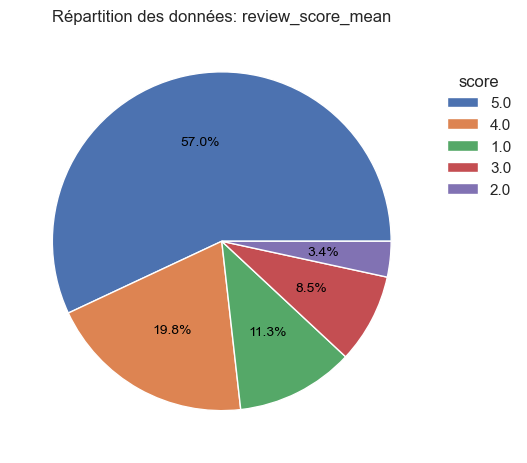

In [83]:
# Répartition des données de la variable review_score_mean
plt.title('Répartition des données: review_score_mean', size=12)
wedges, texts, autotexts = plt.pie(df_group['review_score_mean'].round().value_counts(),
                                   autopct='%1.1f%%', textprops={'fontsize': 10, 
                                     'color' : 'Black'})
    
ax = plt.gca()
sns.set_theme()
ax.legend(wedges, df_group['review_score_mean'].round().value_counts().index,
          title='score',
          loc="center left",
          fontsize=11,
          bbox_to_anchor=(1, 0, 1, 1.5))
plt.show()

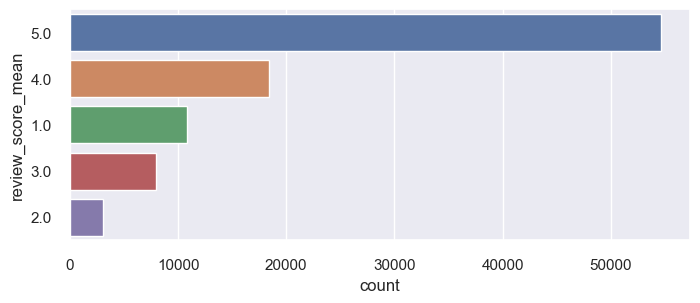

In [84]:
# visualisation de la répartition des données de la variable review_score_mean
plt.figure(figsize=(8, 3))
review_score_mean = df_group['review_score_mean'].round().value_counts().index
sns.countplot(y='review_score_mean', order=review_score_mean, data=df_group);

On peut conclure que la majorité des clients ont donné un score de 5, ce qui représente 57% des avis. Cela suggère que la plupart des clients sont satisfaits de leur expérience d'achat. Cependant, il est important de prendre en compte les autres scores pour avoir une vision plus globale de la satisfaction client et identifier les aspects qui peuvent être améliorés pour offrir une expérience encore meilleure.

### payment_sequential_mean
Nombre de moyens de paiement différents utilisés pour passer une commande (plusieurs méthodes de paiement)

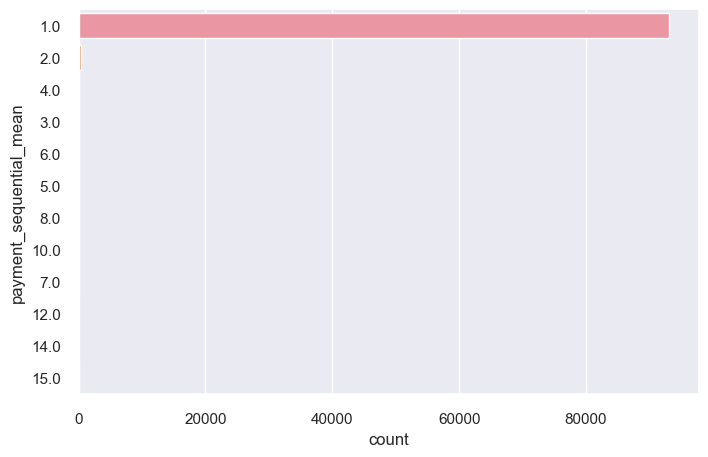

In [85]:
# visualisation de la répartition des données de la variable payment_sequential
plt.figure(figsize=(8, 5))
payment_sequential_mean = df_group['payment_sequential_mean'].round().value_counts().index
sns.countplot(y='payment_sequential_mean', order=payment_sequential_mean, data=df_group);

### 'payment_installments_mean' :  
Nombre d'échéances de paiement

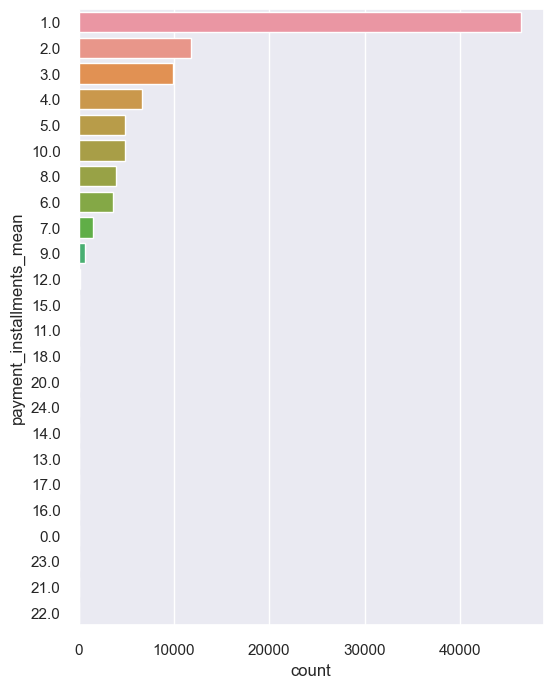

In [86]:
# visualisation de la répartition des données de la variable payment_installments
plt.figure(figsize=(6, 8))
payment_installments_mean = df_group['payment_installments_mean'].round().value_counts().index
sns.countplot(y='payment_installments_mean', order=payment_installments_mean, data=df_group);

La majorité des valeurs pour les variables "payment_sequential_mean" et "payment_installments_mean" est égale à 1, donc on peut conclure que la plupart des clients ont effectué des paiements uniques, sans fractionner le paiement en plusieurs versements ou en utilisant plusieurs méthodes de paiement. 

Cela peut indiquer que la majorité des clients préfèrent effectuer des paiements simples et directs, sans utiliser de méthodes de paiement plus complexes.

Cette information peut être utile pour comprendre les habitudes de paiement des clients et ainsi adapter leur processus de paiement en conséquence. Par exemple, en offrant des méthodes de paiement simples et directes, on peut améliorer l'expérience d'achat pour les clients et encourager des achats plus fréquents et de plus grande valeur. 

Pour les clients qui ont fractionnés les paiements et/ou utilisé plusieurs méthodes de paiement, on peut explorer des options pour offrir des plans de paiement flexibles ou des options de paiement plus diverses pour répondre aux besoins de ces clients.

### order_status_last

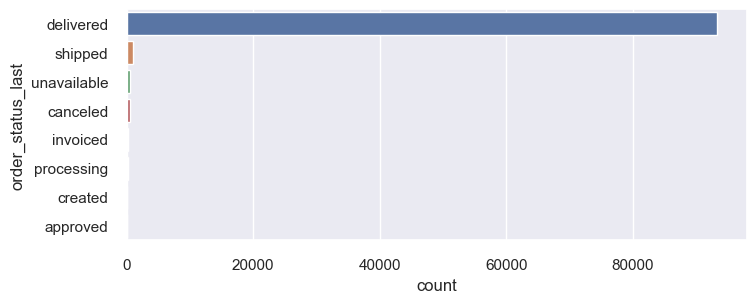

In [87]:
# visualisation de la répartition des données de la variable order_status_last
plt.figure(figsize=(8, 3))
order_status_last = df_group['order_status_last'].value_counts().index
sns.countplot(y='order_status_last', order=order_status_last, data=df_group);

In [88]:
df_group.columns

Index(['customer_unique_id', 'customer_id_nunique', 'customer_city_last',
       'customer_state_last', 'customer_zip_code_prefix_last',
       'order_id_nunique', 'order_id_count', 'récence_mean',
       'Rapidité_livraison_mean', 'order_status_last', 'review_score_mean',
       'payment_sequential_mean', 'payment_type_last',
       'order_purchase_timestamp_first', 'order_purchase_timestamp_last',
       'payment_installments_mean', 'payment_value_sum', 'order_item_id_last',
       'product_id_last', 'price_mean', 'freight_value_mean', 'seller_id_last',
       'seller_zip_code_prefix_last', 'seller_city_last', 'seller_state_last',
       'latitude_client_mean', 'longitude_client_mean',
       'latitude_vendeur_mean', 'longitude_vendeur_mean', '%_frais_livraison'],
      dtype='object')

In [89]:
data = df_group.copy()

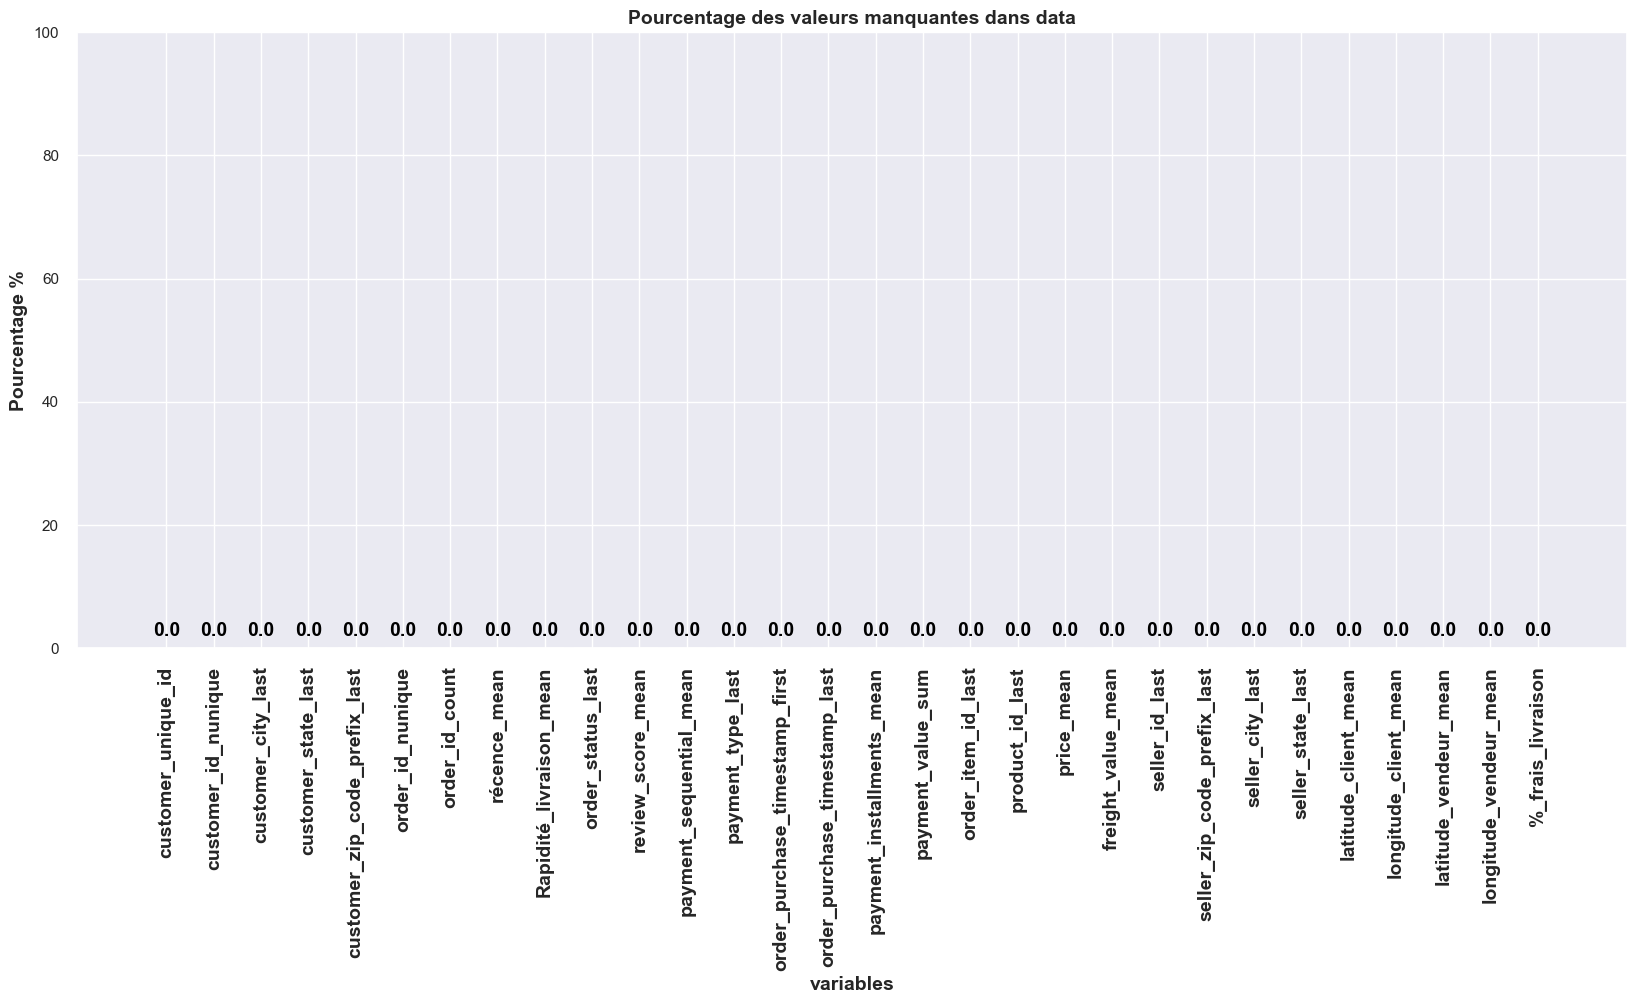

In [90]:
# Représentation graphique du pourcentage des valeurs manquantes pour chaque variable

sns.set_theme()
plt.figure(figsize=(20,8))
df_nan = (data.isna().mean()*100).round(1)
barplot=plt.bar(df_nan.keys(), df_nan.values, color="blue")
plt.bar_label(barplot, labels=df_nan.values, label_type= "edge", 
              weight='bold', padding=6, color= 'black', fontsize=14)
plt.xticks(rotation=90, weight='bold', fontsize=14)
plt.ylim([0,100])
plt.ylabel("Pourcentage %", weight='bold', fontsize=14)
plt.xlabel('variables', weight='bold', fontsize=14)
plt.title('Pourcentage des valeurs manquantes dans data', weight='bold', fontsize=14)
plt.show()

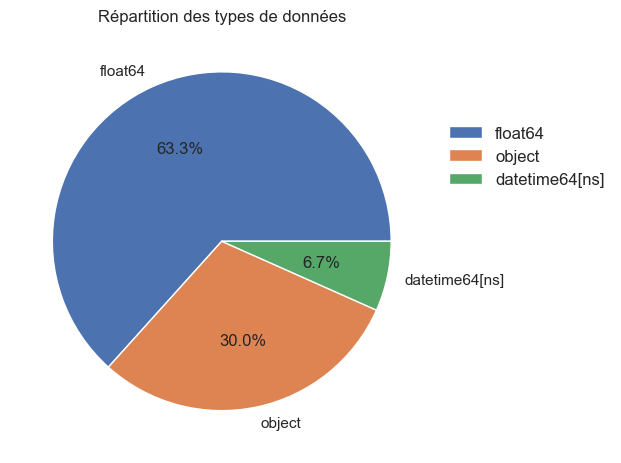

In [91]:
# visualisation de types des données dans le jeu de données df_Seattle

data.dtypes.value_counts().plot(kind='pie', autopct='%1.1f%%', 
                                   title="Répartition des types de données",
                                   legend=False, label="")

ax = plt.gca()
ax.legend(loc="center left",
          fontsize=12,
          bbox_to_anchor=(1, 0.2, 0.5, 1))
sns.set_theme()
plt.show()

In [92]:
# Enregistrez le DataFrame en tant que fichier csv à l'aide de la méthode to_csv() 
data.to_csv('data.csv', index=False)

In [93]:
# Enregistrez le DataFrame en tant que fichier csv à l'aide de la méthode to_csv() 
df.to_csv('df.csv', index=False)

In [94]:
# Enregistrez le DataFrame en tant que fichier csv à l'aide de la méthode to_csv() 
df_group.to_csv('df_group.csv', index=False)